# Generating Synthetic Power Grids topologies using ERG 

In [1]:
#importing libraries

import warnings
warnings.filterwarnings("ignore")

import load_pglib_opf as lp
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pg_utils as sc
from tqdm import tqdm
import pg_ergm_eest as est
import pg_ham_comp as hc
import matplotlib.pylab as pylab

### Reference Grid selection

In the next cell we select the model type as well as the reference grid

In [3]:
mod_type = '_edg_tri_2tri'
obs_comp = getattr(hc,'obs'+mod_type)
fast_obs_comp = getattr(hc,'fast_obs'+mod_type)
name='118_ieee'
rmean_list=[]

In [4]:
#create file used to store the estimation results
file = open("data3_"+name+mod_type+".txt", "w")
file.write("Simulation data on grid "+name+" for model "+mod_type+"\n")

#parsing the .m file into a suitable format, and perform some sanity checks
ordmat,ordlist,buslist,countlist = lp.pow_parser(name)
print("Number of connecetd components in the graph:" ,nx.number_connected_components(nx.from_numpy_array(ordmat)))
k1,k2,k3,q1,q2,q3 = hc.avg_degreetype(ordmat,ordlist)
genobs = hc.obs_edg_tri_2tri(ordmat,q1,q2,q3)
countlist = [q1,q2,q3]
print(countlist)

Number of connecetd components in the graph: 1
[54, 56, 8]


### Parameter Estimation

In the following we generate a starting point for the betas estimation. The EE method works in principle with any starting point, provided that is 'close enough' to the target point. Our experiments showed that the algorithm converges if the parameters in the starting point have the same sign and are of the same order of magnitude as the real ones. Thus, in the following cell we compute, among other quantities, the analytical value of the (edge-)parameters according to the free-energy partial derivatives (see https://doi.org/10.48550/arXiv.1210.7828). For the k-triangle count parameters we use an educated guess.

In [5]:

obs,betas = hc.comp_obs_and_betas(mod_type,ordmat,ordlist,countlist,startguess=np.array([1, -1]))
n = len(ordmat)
startconn1 = est.generate_connected_adj(n)
randper = np.random.permutation(n)
startconn = est.reorder_rows(startconn1,randper)
mix = n*n*np.log(n)
print(betas)
step = int(n/3)

100%|██████████| 3000/3000 [00:01<00:00, 1749.09it/s]


no convergence
48.503979911784306
84.4378631230375
12.062551874719643
22.75200880764068
9.802809379386543
2.0279415901225053
[-3.685 -3.905 -3.905 -4.62  -4.18  -2.805  1.    -1.   ]


To better visualize how the algorithm work we choose as a starting point an educated guess of sign and magnitude of each parameter based on the previous estimation.

In [6]:
#estimate the betas using Equilibrium Expectation
betas = np.array([-2,-2,-2,-2,-2,-2,1,-1], dtype=float)
EEparams,obslist,parlist = est.EEsparse(ordmat,obs,betas,countlist,obs_comp,fast_obs_comp,5000000,0.001,0.001,step)

  0%|          | 3986/5000000 [00:01<14:59, 5555.20it/s]

[-2.01807217 -2.01807217 -2.01605611 -2.01807217 -2.01807217 -2.004002
  0.99103592 -0.998996  ]
[-2.03630764 -2.03630764 -2.03427336 -2.03630764 -2.03630764 -2.01404207
  0.98215219 -1.00802302]


  0%|          | 7462/5000000 [00:01<09:49, 8468.17it/s]

[-2.05470789 -2.05470789 -2.05265523 -2.05470789 -2.05470789 -2.01404207
  0.97334809 -1.0171316 ]
[-2.0732744  -2.0732744  -2.0712032  -2.0732744  -2.0732744  -2.01404207
  0.96462292 -1.02632248]


  0%|          | 11655/5000000 [00:01<08:55, 9313.30it/s]

[-2.09200868 -2.09200868 -2.08991876 -2.09200868 -2.09200868 -2.01404207
  0.95597596 -1.03559642]
[-2.11091225 -2.11091225 -2.10880344 -2.11091225 -2.11091225 -2.01404207
  0.94740651 -1.04495416]


  0%|          | 15568/5000000 [00:02<09:38, 8613.10it/s]

[-2.12998663 -2.12998663 -2.12785877 -2.12998663 -2.12998663 -2.01404207
  0.93891388 -1.05439645]


  0%|          | 17268/5000000 [00:02<11:03, 7506.01it/s]

[-2.14923337 -2.14923337 -2.14708628 -2.14923337 -2.14923337 -1.99798601
  0.93049737 -1.06392406]


  0%|          | 18741/5000000 [00:02<12:28, 6652.47it/s]

[-2.16865402 -2.16865402 -2.16648753 -2.16865402 -2.16865402 -1.9800759
  0.92215632 -1.07353777]


  0%|          | 20909/5000000 [00:03<11:45, 7061.23it/s]

[-2.18825016 -2.18825016 -2.1860641  -2.18825016 -2.18825016 -1.96232633
  0.91389003 -1.08323835]


  0%|          | 23099/5000000 [00:03<11:56, 6944.23it/s]

[-2.20802337 -2.20802337 -2.20581755 -2.20802337 -2.20802337 -1.94473588
  0.90569784 -1.09302658]


  1%|          | 25116/5000000 [00:03<09:41, 8549.00it/s]

[-2.22797526 -2.22797526 -2.22574951 -2.22797526 -2.22797526 -1.9273031
  0.89757909 -1.10290326]


  1%|          | 27012/5000000 [00:03<09:12, 8997.68it/s]

[-2.24810743 -2.24810743 -2.24586157 -2.24810743 -2.24810743 -1.91193853
  0.88953312 -1.11286919]


  1%|          | 29968/5000000 [00:04<08:39, 9571.42it/s]

[-2.26842152 -2.26842152 -2.26615536 -2.26842152 -2.26842152 -1.91002468
  0.88155927 -1.12292517]


  1%|          | 31891/5000000 [00:04<08:49, 9390.61it/s]

[-2.28891916 -2.28891916 -2.28663253 -2.28891916 -2.28891916 -1.90430034
  0.8736569  -1.13307202]


  1%|          | 33858/5000000 [00:04<08:42, 9508.19it/s]

[-2.30960203 -2.30960203 -2.30729474 -2.30960203 -2.30960203 -1.90619701
  0.86582536 -1.14331055]


  1%|          | 36034/5000000 [00:04<08:09, 10151.04it/s]

[-2.33047179 -2.33047179 -2.32814365 -2.33047179 -2.33047179 -1.92342157
  0.85806403 -1.1536416 ]


  1%|          | 39113/5000000 [00:05<08:42, 9491.58it/s] 

[-2.35153013 -2.35153013 -2.34918095 -2.35153013 -2.35153013 -1.93305793
  0.85037228 -1.164066  ]


  1%|          | 41196/5000000 [00:05<08:30, 9717.79it/s]

[-2.37277875 -2.37277875 -2.37040834 -2.37277875 -2.37277875 -1.94468531
  0.84274947 -1.1745846 ]


  1%|          | 43327/5000000 [00:05<08:06, 10191.06it/s]

[-2.39421938 -2.39421938 -2.39182755 -2.39421938 -2.39421938 -1.93498131
  0.83519499 -1.18519825]


  1%|          | 46559/5000000 [00:05<08:03, 10247.53it/s]

[-2.41585375 -2.41585375 -2.41344031 -2.41585375 -2.41585375 -1.92532574
  0.82770823 -1.1959078 ]


  1%|          | 48676/5000000 [00:06<08:03, 10234.85it/s]

[-2.43768361 -2.43768361 -2.43524836 -2.43768361 -2.43768361 -1.90806696
  0.82028859 -1.20671412]


  1%|          | 50824/5000000 [00:06<07:55, 10406.63it/s]

[-2.45971072 -2.45971072 -2.45725347 -2.45971072 -2.45971072 -1.90615508
  0.81293545 -1.21761809]


  1%|          | 52885/5000000 [00:06<08:07, 10148.68it/s]

[-2.48193687 -2.48193687 -2.47945742 -2.48193687 -2.48193687 -1.9214578
  0.80564823 -1.22862059]


  1%|          | 56320/5000000 [00:06<07:37, 10807.04it/s]

[-2.50436386 -2.50436386 -2.501862   -2.50436386 -2.50436386 -1.93494842
  0.79842633 -1.23972251]


  1%|          | 58535/5000000 [00:07<07:32, 10920.75it/s]

[-2.52699351 -2.52699351 -2.52446904 -2.52699351 -2.52699351 -1.94853376
  0.79126917 -1.25092475]


  1%|          | 60783/5000000 [00:07<07:28, 11012.06it/s]

[-2.54982763 -2.54982763 -2.54728035 -2.54982763 -2.54982763 -1.93687175
  0.78417617 -1.26222821]


  1%|▏         | 63165/5000000 [00:07<07:17, 11295.68it/s]

[-2.57286809 -2.57286809 -2.57029779 -2.57286809 -2.57286809 -1.91950947
  0.77714675 -1.27363381]


  1%|▏         | 66648/5000000 [00:07<07:10, 11452.39it/s]

[-2.59611674 -2.59611674 -2.59352322 -2.59611674 -2.59611674 -1.91375669
  0.77018034 -1.28129346]


  1%|▏         | 69054/5000000 [00:07<07:08, 11509.64it/s]

[-2.61957547 -2.61957547 -2.61695851 -2.61957547 -2.61957547 -1.92334271
  0.76327638 -1.28642375]


  1%|▏         | 71429/5000000 [00:08<07:08, 11508.90it/s]

[-2.64324617 -2.64324617 -2.64060557 -2.64324617 -2.64324617 -1.92911851
  0.7564343  -1.29416032]


  1%|▏         | 73731/5000000 [00:08<07:24, 11084.49it/s]

[-2.66713077 -2.66713077 -2.6644663  -2.66713077 -2.66713077 -1.94655019
  0.74965356 -1.30585446]


  2%|▏         | 77147/5000000 [00:08<07:20, 11184.26it/s]

[-2.69123119 -2.69123119 -2.68854265 -2.69123119 -2.69123119 -1.96413938
  0.7429336  -1.31370921]


  2%|▏         | 81029/5000000 [00:09<06:39, 12297.71it/s]

[-2.71554938 -2.71554938 -2.71283654 -2.71554938 -2.71554938 -1.98188751
  0.73627389 -1.31370395]


  2%|▏         | 83514/5000000 [00:09<06:49, 12003.15it/s]

[-2.74008731 -2.74008731 -2.73734996 -2.74008731 -2.74008731 -1.99979601
  0.72967386 -1.32160458]


  2%|▏         | 86000/5000000 [00:09<06:44, 12138.05it/s]

[-2.76484697 -2.76484697 -2.76208489 -2.76484697 -2.76484697 -2.01786634
  0.72313301 -1.30975761]


  2%|▏         | 88544/5000000 [00:09<06:49, 11986.29it/s]

[-2.78983036 -2.78983036 -2.78704332 -2.78983036 -2.78983036 -2.03609995
  0.71665078 -1.29801683]


  2%|▏         | 92202/5000000 [00:09<06:54, 11839.78it/s]

[-2.8150395  -2.8150395  -2.81222728 -2.8150395  -2.8150395  -2.04834713
  0.71022666 -1.2863813 ]


  2%|▏         | 94638/5000000 [00:10<06:49, 11974.57it/s]

[-2.84047644 -2.84047644 -2.8376388  -2.84047644 -2.84047644 -2.04834713
  0.70386013 -1.27485007]


  2%|▏         | 98401/5000000 [00:10<06:40, 12250.57it/s]

[-2.86614322 -2.86614322 -2.86327994 -2.86614322 -2.86614322 -2.05449832
  0.69755067 -1.26848729]


  2%|▏         | 102019/5000000 [00:10<07:11, 11352.84it/s]

[-2.89204193 -2.89204193 -2.88915278 -2.89204193 -2.89204193 -2.07306294
  0.69129777 -1.25711646]


  2%|▏         | 104588/5000000 [00:11<07:28, 10923.70it/s]

[-2.91817467 -2.91817467 -2.91525941 -2.91817467 -2.91817467 -2.09179531
  0.68510092 -1.24959135]


  2%|▏         | 108428/5000000 [00:11<06:47, 12010.68it/s]

[-2.94454354 -2.94454354 -2.94160194 -2.94454354 -2.94454354 -2.11069694
  0.67895962 -1.2383899 ]


  2%|▏         | 112198/5000000 [00:11<06:34, 12403.96it/s]

[-2.97115068 -2.97115068 -2.9681825  -2.97115068 -2.97115068 -2.12976938
  0.67287336 -1.22728887]


  2%|▏         | 116059/5000000 [00:11<06:25, 12680.88it/s]

[-2.99799825 -2.99799825 -2.99500325 -2.99799825 -2.99799825 -2.13615867
  0.66684167 -1.21628735]


  2%|▏         | 118772/5000000 [00:12<06:11, 13140.82it/s]

[-3.02508841 -3.02508841 -3.02206635 -3.02508841 -3.02508841 -2.12125034
  0.66086405 -1.20538445]


  2%|▏         | 122672/5000000 [00:12<06:27, 12581.77it/s]

[-3.05242337 -3.05242337 -3.04937399 -3.05242337 -3.05242337 -2.10223528
  0.65494001 -1.19457928]


  3%|▎         | 126771/5000000 [00:12<06:02, 13442.35it/s]

[-3.08000532 -3.08000532 -3.07692839 -3.08000532 -3.08000532 -2.0917451
  0.6516712  -1.18387097]


  3%|▎         | 131334/5000000 [00:13<05:39, 14323.00it/s]

[-3.10783651 -3.10783651 -3.10473178 -3.10783651 -3.10783651 -2.10222267
  0.64582956 -1.17325866]


  3%|▎         | 135410/5000000 [00:13<06:36, 12259.38it/s]

[-3.13591918 -3.13591918 -3.13278639 -3.13591918 -3.13591918 -2.09173255
  0.64004029 -1.16274147]


  3%|▎         | 139270/5000000 [00:13<06:33, 12341.74it/s]

[-3.15793342 -3.16425561 -3.16109451 -3.16425561 -3.16425561 -2.08755118
  0.63684521 -1.15231855]


  3%|▎         | 142710/5000000 [00:14<07:54, 10236.11it/s]

[-3.14845965 -3.19284809 -3.18965843 -3.19284809 -3.19284809 -2.07505714
  0.63811762 -1.14198907]


  3%|▎         | 147038/5000000 [00:14<07:57, 10154.56it/s]

[-3.17056192 -3.22169893 -3.21848045 -3.22169893 -3.22169893 -2.06057525
  0.64324047 -1.13175219]


  3%|▎         | 153184/5000000 [00:15<06:28, 12471.11it/s]

[-3.19921138 -3.25081048 -3.24756291 -3.25081048 -3.25081048 -2.07711766
  0.64388113 -1.12160707]


  3%|▎         | 156307/5000000 [00:15<05:45, 14003.22it/s]

[-3.22811973 -3.28018507 -3.27690816 -3.28018507 -3.28018507 -2.08126981
  0.6496993  -1.11155289]


  3%|▎         | 162308/5000000 [00:15<05:27, 14793.34it/s]

[-3.25728929 -3.3098251  -3.30651858 -3.3098251  -3.3098251  -2.08334483
  0.6496967  -1.10158883]


  3%|▎         | 166781/5000000 [00:15<05:27, 14745.83it/s]

[-3.28672243 -3.33973296 -3.33639656 -3.33973296 -3.33973296 -2.10007004
  0.65229808 -1.0917141 ]


  3%|▎         | 171761/5000000 [00:16<05:01, 16003.20it/s]

[-3.31642153 -3.36991107 -3.35982152 -3.36991107 -3.36991107 -2.09796577
  0.6581923  -1.08192788]


  3%|▎         | 174845/5000000 [00:16<05:48, 13859.90it/s]

[-3.34638899 -3.40036187 -3.37664751 -3.40036187 -3.40036187 -2.11692317
  0.66016687 -1.07222939]


  4%|▎         | 179072/5000000 [00:16<06:17, 12780.75it/s]

[-3.37662725 -3.43108782 -3.40715918 -3.43108782 -3.43108782 -2.13605187
  0.6661322  -1.06261784]


  4%|▎         | 185256/5000000 [00:17<05:31, 14519.52it/s]

[-3.40713873 -3.44827416 -3.43794655 -3.46209142 -3.46209142 -2.15535341
  0.67215142 -1.05309244]


  4%|▍         | 191129/5000000 [00:17<05:43, 14008.52it/s]

[-3.4207809  -3.47943305 -3.444819   -3.49337517 -3.49337517 -2.16615175
  0.67822504 -1.04365243]


  4%|▍         | 196111/5000000 [00:17<05:08, 15557.81it/s]

[-3.40711148 -3.5108735  -3.47594667 -3.5249416  -3.52142018 -2.15534048
  0.68435354 -1.03429704]


  4%|▍         | 202408/5000000 [00:18<05:36, 14269.92it/s]

[-3.43789842 -3.54259805 -3.50735562 -3.55679327 -3.55324003 -2.15749582
  0.69053741 -1.02502552]


  4%|▍         | 208838/5000000 [00:18<05:14, 15255.98it/s]

[-3.46896356 -3.57460927 -3.53904838 -3.58893275 -3.55677904 -2.15533832
  0.69677717 -1.0158371 ]


  4%|▍         | 215386/5000000 [00:19<04:58, 16024.48it/s]

[-3.43786748 -3.60690974 -3.57102752 -3.62136265 -3.5889184  -2.15748935
  0.70307331 -1.00673105]


  4%|▍         | 220135/5000000 [00:19<05:16, 15112.44it/s]

[-3.43785373 -3.63950208 -3.60329562 -3.65408559 -3.62134817 -2.17480979
  0.70942633 -0.99770663]


  5%|▍         | 227103/5000000 [00:19<04:41, 16940.15it/s]

[-3.46891847 -3.66139009 -3.6177232  -3.68710422 -3.62495864 -2.17262846
  0.71583677 -0.98876311]


  5%|▍         | 232396/5000000 [00:20<05:22, 14796.03it/s]

[-3.5002639  -3.65040595 -3.63948024 -3.7204212  -3.62132282 -2.16611493
  0.72230513 -0.97989975]


  5%|▍         | 238373/5000000 [00:20<05:34, 14233.19it/s]

[-3.53189258 -3.63945476 -3.63582985 -3.75403924 -3.6540454  -2.18350462
  0.72883194 -0.97111585]


  5%|▍         | 246543/5000000 [00:21<05:03, 15658.88it/s]

[-3.56380706 -3.64307965 -3.60323797 -3.78796105 -3.68706366 -2.20323495
  0.73541773 -0.96241068]


  5%|▌         | 251518/5000000 [00:21<04:57, 15976.07it/s]

[-3.57450203 -3.63215407 -3.57451275 -3.82218939 -3.72038027 -2.21648745
  0.74206303 -0.95378355]


  5%|▌         | 258372/5000000 [00:22<04:47, 16474.36it/s]

[-3.58881432 -3.65765189 -3.56736017 -3.85672701 -3.75399794 -2.23204949
  0.74876837 -0.94523376]


  5%|▌         | 265281/5000000 [00:22<04:42, 16787.51it/s]

[-3.57089896 -3.66862482 -3.53892097 -3.89157672 -3.76525991 -2.24772079
  0.7555343  -0.9367606 ]


  5%|▌         | 272117/5000000 [00:22<04:58, 15860.33it/s]

[-3.53888912 -3.70177482 -3.54954836 -3.92674134 -3.7315078  -2.26576562
  0.76236137 -0.9283634 ]


  6%|▌         | 278854/5000000 [00:23<04:52, 16152.64it/s]

[-3.50716622 -3.73522437 -3.56376786 -3.9622237  -3.72403735 -2.28395531
  0.76925014 -0.92004148]


  6%|▌         | 285359/5000000 [00:23<04:55, 15944.61it/s]

[-3.47572769 -3.76897617 -3.5887892  -3.99802669 -3.7464375  -2.29769335
  0.77620115 -0.91179415]


  6%|▌         | 292644/5000000 [00:24<04:41, 16713.22it/s]

[-3.44457098 -3.79923372 -3.57444841 -4.03415319 -3.77651412 -2.29998644
  0.78321496 -0.90362075]


  6%|▌         | 299325/5000000 [00:24<04:56, 15833.74it/s]

[-3.47569641 -3.76517707 -3.58876049 -4.07060614 -3.79163526 -2.27936917
  0.79029216 -0.89552062]


  6%|▌         | 305878/5000000 [00:25<05:23, 14518.71it/s]

[-3.5071031  -3.73142571 -3.62118883 -4.10738848 -3.80681695 -2.25893671
  0.79743331 -0.88749309]


  6%|▋         | 312714/5000000 [00:25<06:43, 11616.32it/s]

[-3.53879357 -3.6979769  -3.6539102  -4.14450319 -3.80680173 -2.24991451
  0.80463898 -0.87953753]


  6%|▋         | 322523/5000000 [00:26<04:54, 15895.65it/s]

[-3.5140927  -3.6979621  -3.67588487 -4.17777549 -3.84120031 -2.25216217
  0.81190977 -0.87165328]


  7%|▋         | 328919/5000000 [00:26<05:13, 14911.74it/s]

[-3.48259207 -3.69795101 -3.70539508 -4.21552622 -3.87590972 -2.2725129
  0.81924625 -0.86383971]


  7%|▋         | 335104/5000000 [00:27<05:08, 15106.68it/s]

[-3.45137383 -3.73136601 -3.73141078 -4.25361807 -3.91093276 -2.29304752
  0.82664903 -0.85609618]


  7%|▋         | 342158/5000000 [00:27<04:34, 16975.91it/s]

[-3.44790866 -3.76508294 -3.76136676 -4.28776636 -3.92266945 -2.31145623
  0.8341187  -0.84842206]


  7%|▋         | 350793/5000000 [00:27<04:29, 17224.86it/s]

[-3.43756496 -3.76130282 -3.78398767 -4.32651097 -3.95811502 -2.31144698
  0.84165587 -0.84081673]


  7%|▋         | 357927/5000000 [00:28<04:27, 17334.84it/s]

[-3.46862709 -3.75752648 -3.765098   -4.36124445 -3.95019485 -2.30681948
  0.84926114 -0.83327958]


  7%|▋         | 364983/5000000 [00:28<04:29, 17202.95it/s]

[-3.46861321 -3.75000394 -3.73508243 -4.40065302 -3.98190724 -2.32301574
  0.85693514 -0.82580999]


  7%|▋         | 372327/5000000 [00:29<04:33, 16938.55it/s]

[-3.4999559  -3.78388929 -3.70160084 -4.44041769 -3.96996949 -2.3230111
  0.86467847 -0.81840736]


  8%|▊         | 380625/5000000 [00:29<04:49, 15942.87it/s]

[-3.51748719 -3.81808083 -3.68312245 -4.42709647 -4.00584247 -2.33231709
  0.87249178 -0.81107109]


  8%|▊         | 387843/5000000 [00:30<04:29, 17108.44it/s]

[-3.4999279  -3.85258133 -3.65376039 -4.40059581 -4.03800159 -2.3533921
  0.88037569 -0.80380058]


  8%|▊         | 394662/5000000 [00:30<04:39, 16495.98it/s]

[-3.4754983  -3.85256592 -3.65374578 -4.43148812 -4.07448932 -2.37228527
  0.88833084 -0.79659525]


  8%|▊         | 403259/5000000 [00:31<04:28, 17111.21it/s]

[-3.45124268 -3.84485311 -3.66471065 -4.47153142 -4.09899335 -2.39372143
  0.89635787 -0.7894545 ]


  8%|▊         | 410133/5000000 [00:31<04:29, 17060.70it/s]

[-3.46159984 -3.82948909 -3.63185988 -4.44920953 -4.09488617 -2.4153513
  0.90445744 -0.78237776]


  8%|▊         | 419062/5000000 [00:32<04:20, 17566.63it/s]

[-3.47893553 -3.81418647 -3.63911631 -4.43143051 -4.07852302 -2.4226046
  0.91263019 -0.77536446]


  8%|▊         | 424234/5000000 [00:32<04:54, 15533.36it/s]

[-3.4998614  -3.84865178 -3.63183445 -4.43584863 -4.09894826 -2.41534164
  0.92087679 -0.76841403]


  9%|▊         | 432362/5000000 [00:32<04:43, 16115.52it/s]

[-3.47891118 -3.85248502 -3.62819173 -4.42696809 -4.07034156 -2.41051096
  0.92919791 -0.7615259 ]


  9%|▉         | 441310/5000000 [00:33<05:11, 14618.47it/s]

[-3.4998334  -3.87177826 -3.63181266 -4.46697054 -4.0419345  -2.4153344
  0.93759422 -0.75469952]


  9%|▉         | 450605/5000000 [00:34<05:23, 14056.30it/s]

[-3.51384672 -3.83707132 -3.66463003 -4.49383497 -4.0459643  -2.39607921
  0.9460664  -0.74793433]


  9%|▉         | 456296/5000000 [00:34<05:22, 14089.24it/s]

[-3.54559813 -3.82556013 -3.69035952 -4.51182827 -4.04999811 -2.38173863
  0.95461514 -0.74122979]


  9%|▉         | 463707/5000000 [00:35<05:06, 14805.51it/s]

[-3.57763646 -3.82172311 -3.69774023 -4.55259752 -4.08659424 -2.38172911
  0.96324112 -0.73458534]


  9%|▉         | 471832/5000000 [00:35<04:52, 15458.75it/s]

[-3.60996428 -3.8408623  -3.66826164 -4.59373518 -4.1070599  -2.40325061
  0.97194505 -0.72800045]


 10%|▉         | 479542/5000000 [00:36<06:24, 11769.20it/s]

[-3.62804661 -3.80643249 -3.64630338 -4.5937214  -4.07431819 -2.42496658
  0.98072763 -0.7214746 ]


 10%|▉         | 489167/5000000 [00:36<05:11, 14475.62it/s]

[-3.60272274 -3.77231131 -3.63173639 -4.6213481  -4.05803723 -2.44687879
  0.98958956 -0.71500724]


 10%|▉         | 496494/5000000 [00:37<04:17, 17483.11it/s]

[-3.57042763 -3.7609944  -3.66089218 -4.59368465 -4.04991712 -2.46898899
  0.99853158 -0.70859785]


 10%|█         | 505712/5000000 [00:37<04:06, 18235.52it/s]

[-3.53842202 -3.79497906 -3.63898166 -4.62593707 -4.01361332 -2.49129898
  1.00755439 -0.70224592]


 10%|█         | 512839/5000000 [00:38<04:25, 16916.28it/s]

[-3.50670331 -3.81780212 -3.61719867 -4.6444593  -4.00157651 -2.51381057
  1.01665874 -0.69595093]


 10%|█         | 520944/5000000 [00:38<04:50, 15438.74it/s]

[-3.49618672 -3.81396906 -3.59195411 -4.60743341 -4.03773509 -2.53652557
  1.02584535 -0.68971237]


 11%|█         | 529243/5000000 [00:39<04:33, 16354.56it/s]

[-3.52073005 -3.81776776 -3.55975554 -4.63050744 -4.06608417 -2.55944583
  1.03511498 -0.68352973]


 11%|█         | 536488/5000000 [00:39<04:07, 18007.88it/s]

[-3.49266259 -3.79111963 -3.5847487  -4.62124181 -4.09872693 -2.57999321
  1.04446837 -0.67740251]


 11%|█         | 545724/5000000 [00:40<04:08, 17902.32it/s]

[-3.46135407 -3.80249296 -3.61714079 -4.62584918 -4.13576337 -2.57482807
  1.05390627 -0.67133022]


 11%|█         | 552582/5000000 [00:40<04:31, 16373.82it/s]

[-3.49263116 -3.83685261 -3.64982558 -4.58438268 -4.1440266  -2.57739775
  1.06342945 -0.66531236]


 11%|█         | 561355/5000000 [00:41<04:18, 17190.81it/s]

[-3.51714953 -3.83683726 -3.66810391 -4.58895329 -4.16894883 -2.58513768
  1.07303869 -0.65934844]


 11%|█▏        | 568230/5000000 [00:41<04:35, 16097.32it/s]

[-3.54893079 -3.87150725 -3.67175733 -4.54781753 -4.13985359 -2.59030536
  1.08273476 -0.65343799]


 12%|█▏        | 575143/5000000 [00:42<04:30, 16386.51it/s]

[-3.56670383 -3.90649051 -3.63884339 -4.51607364 -4.17726166 -2.60849198
  1.09251844 -0.64758052]


 12%|█▏        | 581726/5000000 [00:42<05:02, 14629.38it/s]

[-3.57025983 -3.91429566 -3.64976719 -4.55688126 -4.16056934 -2.63206253
  1.10239053 -0.64177555]


 12%|█▏        | 590112/5000000 [00:43<04:23, 16715.47it/s]

[-3.60252099 -3.88309067 -3.66804889 -4.57512699 -4.13153258 -2.65584607
  1.11235183 -0.63602262]


 12%|█▏        | 597541/5000000 [00:43<04:03, 18087.67it/s]

[-3.60610909 -3.85599045 -3.66436985 -4.54774022 -4.14393543 -2.66915189
  1.12240313 -0.63032126]


 12%|█▏        | 606678/5000000 [00:43<04:02, 18128.29it/s]

[-3.63142408 -3.87530125 -3.64607731 -4.55683113 -4.10678885 -2.68252436
  1.13254526 -0.62467101]


 12%|█▏        | 612129/5000000 [00:44<04:08, 17636.88it/s]

[-3.64961025 -3.9103188  -3.63151123 -4.53862205 -4.06997525 -2.66913854
  1.14277903 -0.6190714 ]


 12%|█▏        | 620707/5000000 [00:44<04:25, 16472.14it/s]

[-3.68258843 -3.92204972 -3.63513184 -4.52501075 -4.03349165 -2.68787597
  1.15310528 -0.613522  ]


 13%|█▎        | 629589/5000000 [00:45<04:11, 17377.72it/s]

[-3.71586461 -3.9102836  -3.6679792  -4.51143575 -3.99733509 -2.67178898
  1.16352484 -0.60802233]


 13%|█▎        | 636796/5000000 [00:45<04:10, 17442.12it/s]

[-3.74569578 -3.87523149 -3.68634844 -4.49790598 -3.98136574 -2.65579827
  1.17403855 -0.60257197]


 13%|█▎        | 645125/5000000 [00:46<04:30, 16090.89it/s]

[-3.74193512 -3.85974608 -3.66062128 -4.51591558 -3.95753322 -2.65844875
  1.18464726 -0.59717046]


 13%|█▎        | 652789/5000000 [00:46<04:57, 14620.91it/s]

[-3.7083921  -3.83280495 -3.68263631 -4.55672177 -3.98133388 -2.63989534
  1.19535183 -0.59181738]


 13%|█▎        | 660016/5000000 [00:47<05:14, 13811.53it/s]

[-3.67514976 -3.85199963 -3.660592   -4.57497144 -4.01730955 -2.62671961
  1.20615313 -0.58651228]


 13%|█▎        | 666663/5000000 [00:47<05:55, 12202.86it/s]

[-3.66046388 -3.8829237  -3.68997943 -4.60708787 -4.04956074 -2.65045487
  1.21705203 -0.58125473]


 14%|█▎        | 675610/5000000 [00:48<05:42, 12624.17it/s]

[-3.63128246 -3.84811685 -3.7233224  -4.57035991 -4.08615291 -2.66906381
  1.22804941 -0.57604432]


 14%|█▎        | 681915/5000000 [00:48<04:49, 14900.75it/s]

[-3.62764029 -3.87125948 -3.75696665 -4.61165806 -4.09022679 -2.66906381
  1.23914617 -0.57088061]


 14%|█▍        | 690258/5000000 [00:49<04:38, 15468.59it/s]

[-3.59512182 -3.9062405  -3.77578532 -4.65332939 -4.08204226 -2.6744046
  1.2503432  -0.56576318]


 14%|█▍        | 698596/5000000 [00:50<04:38, 15431.87it/s]

[-3.60951667 -3.9101311  -3.77577021 -4.63937408 -4.06573451 -2.66638674
  1.26164141 -0.56069164]


 14%|█▍        | 707760/5000000 [00:50<04:47, 14916.22it/s]

[-3.58791005 -3.92971304 -3.79089217 -4.66261273 -4.05760305 -2.66905313
  1.27304171 -0.55566555]


 14%|█▍        | 714241/5000000 [00:51<04:36, 15509.49it/s]

[-3.60587831 -3.9218497  -3.77952331 -4.67660053 -4.0494838  -2.67974537
  1.28454502 -0.55068452]


 14%|█▍        | 721849/5000000 [00:51<04:44, 15015.28it/s]

[-3.61308283 -3.90227183 -3.8136754  -4.71885869 -4.06976768 -2.69586409
  1.29615227 -0.54574813]


 15%|█▍        | 730580/5000000 [00:52<04:06, 17302.18it/s]

[-3.60945892 -3.89835396 -3.8442918  -4.68592092 -4.10654245 -2.7093704
  1.30786441 -0.540856  ]


 15%|█▍        | 738934/5000000 [00:52<04:29, 15800.21it/s]

[-3.64207429 -3.93357982 -3.87515399 -4.64391593 -4.13537462 -2.71207977
  1.31968239 -0.53600772]


 15%|█▍        | 745727/5000000 [00:53<04:11, 16936.43it/s]

[-3.67498438 -3.96515882 -3.87126722 -4.60228748 -4.16024898 -2.70936498
  1.33160715 -0.53120291]


 15%|█▌        | 755250/5000000 [00:53<04:45, 14880.63it/s]

[-3.69708579 -3.98900534 -3.89065842 -4.56103219 -4.15192434 -2.71749849
  1.34363966 -0.52644116]


 15%|█▌        | 763943/5000000 [00:54<04:08, 17071.04it/s]

[-3.6639448  -3.99697534 -3.92189284 -4.54280632 -4.18944148 -2.6931386
  1.3557809  -0.5217221 ]


 15%|█▌        | 772310/5000000 [00:54<04:44, 14850.60it/s]

[-3.6311009  -3.98897342 -3.94153368 -4.50659082 -4.22729763 -2.66899708
  1.36803185 -0.51704533]


 16%|█▌        | 780894/5000000 [00:55<04:13, 16631.93it/s]

[-3.61297805 -3.95321593 -3.93364669 -4.52463519 -4.2442322  -2.64507197
  1.38039351 -0.5124105 ]


 16%|█▌        | 789694/5000000 [00:55<04:00, 17489.08it/s]

[-3.62381696 -3.95320012 -3.90228744 -4.52914171 -4.22728072 -2.62398531
  1.39286686 -0.50781721]


 16%|█▌        | 796880/5000000 [00:56<03:58, 17645.89it/s]

[-3.59133276 -3.96505969 -3.91399818 -4.57006741 -4.2569606  -2.6135051
  1.40545292 -0.50326509]


 16%|█▌        | 805309/5000000 [00:56<04:23, 15892.43it/s]

[-3.55913975 -3.94132478 -3.92967374 -4.57004913 -4.244194   -2.59007742
  1.41815271 -0.49875378]


 16%|█▋        | 814098/5000000 [00:57<04:00, 17435.36it/s]

[-3.58412501 -3.90599442 -3.96518261 -4.53815006 -4.25267813 -2.56685975
  1.43096726 -0.49428291]


 16%|█▋        | 822936/5000000 [00:57<03:58, 17487.73it/s]

[-3.61651147 -3.88649569 -3.98504423 -4.52906471 -4.21877554 -2.5438502
  1.4438976  -0.48985212]


 17%|█▋        | 829374/5000000 [00:58<04:51, 14330.18it/s]

[-3.62374086 -3.85165682 -4.02105342 -4.5654243  -4.19352189 -2.52104691
  1.45694478 -0.48546104]


 17%|█▋        | 837701/5000000 [00:58<05:10, 13397.81it/s]

[-3.60204909 -3.85549691 -3.99698334 -4.57912969 -4.16842358 -2.53620853
  1.47010985 -0.48110933]


 17%|█▋        | 845624/5000000 [00:59<04:38, 14901.92it/s]

[-3.57690669 -3.87093431 -3.96115404 -4.54717179 -4.1559225  -2.55912592
  1.48339389 -0.47679662]


 17%|█▋        | 854146/5000000 [00:59<04:03, 17043.83it/s]

[-3.60201668 -3.87091882 -3.92564593 -4.50641056 -4.1351844  -2.5822504
  1.49679796 -0.47252258]


 17%|█▋        | 861264/5000000 [01:00<04:11, 16466.17it/s]

[-3.59840027 -3.90589677 -3.91778681 -4.53804569 -4.13517613 -2.60558383
  1.50579973 -0.46922436]


 17%|█▋        | 868038/5000000 [01:00<04:42, 14648.69it/s]

[-3.63091571 -3.90978703 -3.88266744 -4.54711722 -4.12277888 -2.60818941
  1.51940626 -0.46501819]


 18%|█▊        | 877578/5000000 [01:01<04:37, 14867.51it/s]

[-3.66006491 -3.87473937 -3.85942574 -4.58820535 -4.08582194 -2.5977697
  1.53313574 -0.46084973]


 18%|█▊        | 886233/5000000 [01:02<03:59, 17204.51it/s]

[-3.67839451 -3.84000588 -3.86713685 -4.62966476 -4.0817198  -2.58998418
  1.54698929 -0.45671863]


 18%|█▊        | 893180/5000000 [01:02<04:26, 15410.99it/s]

[-3.70051643 -3.86696283 -3.83630782 -4.62502122 -4.07762584 -2.56933668
  1.56096801 -0.45262457]


 18%|█▊        | 901400/5000000 [01:02<04:12, 16259.91it/s]

[-3.67836509 -3.90190503 -3.86324267 -4.62038696 -4.07761361 -2.55395915
  1.57507305 -0.4485672 ]


 18%|█▊        | 909036/5000000 [01:03<03:49, 17826.92it/s]

[-3.64539191 -3.93716297 -3.86709431 -4.60652584 -4.11445927 -2.54629984
  1.58296101 -0.4449912 ]


 18%|█▊        | 918126/5000000 [01:03<03:53, 17463.48it/s]

[-3.63082494 -3.97273951 -3.9020377  -4.57895111 -4.15163787 -2.55649521
  1.58929918 -0.44188515]


 19%|█▊        | 925466/5000000 [01:04<03:51, 17606.33it/s]

[-3.6199325  -3.95290759 -3.90202599 -4.53790501 -4.18915242 -2.57959592
  1.59406707 -0.4405595 ]


 19%|█▊        | 934213/5000000 [01:04<03:54, 17329.85it/s]

[-3.58748312 -3.94893889 -3.8670479  -4.49722685 -4.22700595 -2.56929043
  1.60847119 -0.43661029]


 19%|█▉        | 941240/5000000 [01:05<03:58, 17036.86it/s]

[-3.55532462 -3.92137519 -3.83238336 -4.519758   -4.20590474 -2.58991684
  1.62300547 -0.43269647]


 19%|█▉        | 948155/5000000 [01:05<03:56, 17130.94it/s]

[-3.54820688 -3.91352462 -3.85543137 -4.56059891 -4.19748874 -2.59509148
  1.63767109 -0.42881775]


 19%|█▉        | 957349/5000000 [01:06<03:47, 17779.47it/s]

[-3.58026878 -3.94888755 -3.85927136 -4.60180887 -4.1598621  -2.58731399
  1.65246922 -0.42497379]


 19%|█▉        | 963907/5000000 [01:06<04:37, 14548.42it/s]

[-3.59460775 -3.96866358 -3.89414406 -4.62485935 -4.13496111 -2.5873114
  1.66573534 -0.42116429]


 19%|█▉        | 971129/5000000 [01:07<03:55, 17076.00it/s]

[-3.62708893 -4.00452476 -3.92933188 -4.5925777  -4.1349487  -2.60027125
  1.66572867 -0.4211626 ]


 20%|█▉        | 980109/5000000 [01:07<03:47, 17689.55it/s]

[-3.64525339 -3.99251122 -3.91754783 -4.56052138 -4.1432103  -2.60547179
  1.67407064 -0.41906016]


 20%|█▉        | 987367/5000000 [01:07<03:47, 17657.42it/s]

[-3.67084317 -3.9606827  -3.89410123 -4.53322204 -4.1806487  -2.60807205
  1.68919769 -0.41530367]


 20%|█▉        | 994277/5000000 [01:08<04:16, 15634.46it/s]

[-3.68554121 -3.93303702 -3.86692416 -4.51511182 -4.1973922  -2.61590409
  1.70446142 -0.41158085]


 20%|██        | 1002362/5000000 [01:08<04:30, 14758.57it/s]

[-3.69659781 -3.95273367 -3.86304565 -4.55591075 -4.16809428 -2.62113851
  1.71986308 -0.40789141]


 20%|██        | 1012136/5000000 [01:09<04:51, 13664.00it/s]

[-3.7002796  -3.9884509  -3.89405839 -4.54224759 -4.13073114 -2.64218116
  1.72329935 -0.40666774]


 20%|██        | 1020766/5000000 [01:10<03:58, 16713.38it/s]

[-3.66710999 -3.95269809 -3.92532011 -4.58329172 -4.16805677 -2.66605613
  1.73887123 -0.40302233]


 21%|██        | 1027374/5000000 [01:10<04:18, 15371.80it/s]

[-3.65610869 -3.91726578 -3.91354418 -4.58785666 -4.19732084 -2.68745938
  1.75458382 -0.39940961]


 21%|██        | 1036333/5000000 [01:11<04:04, 16215.12it/s]

[-3.68546013 -3.88215108 -3.87846285 -4.62931292 -4.23101717 -2.71174349
  1.77043838 -0.39582927]


 21%|██        | 1042752/5000000 [01:11<04:24, 14952.57it/s]

[-3.71876226 -3.87825729 -3.91350896 -4.67114378 -4.20148875 -2.72805468
  1.77220173 -0.39306637]


 21%|██        | 1049610/5000000 [01:12<05:23, 12228.85it/s]

[-3.72992225 -3.91330155 -3.94887176 -4.6758009  -4.20567763 -2.71987598
  1.77396684 -0.38954289]


 21%|██        | 1056700/5000000 [01:12<05:55, 11086.25it/s]

[-3.74485684 -3.94866247 -3.9845541  -4.63388663 -4.20145934 -2.69819297
  1.78999655 -0.38605099]


 21%|██▏       | 1064072/5000000 [01:13<04:50, 13526.93it/s]

[-3.77869568 -3.93681652 -3.97260444 -4.63386809 -4.18049402 -2.6901038
  1.79357295 -0.3856634 ]


 21%|██▏       | 1070238/5000000 [01:13<04:25, 14791.53it/s]

[-3.81284029 -3.97238992 -3.96465131 -4.67574011 -4.16378878 -2.69278582
  1.7828366  -0.38643395]


 22%|██▏       | 1078379/5000000 [01:14<04:14, 15382.05it/s]

[-3.80901222 -4.00828477 -3.96067477 -4.6897673  -4.19721591 -2.70357313
  1.79894646 -0.38296992]


 22%|██▏       | 1086221/5000000 [01:14<04:11, 15584.23it/s]

[-3.77486791 -4.02835826 -3.92517095 -4.65238021 -4.23514231 -2.69547052
  1.81338851 -0.37953695]


 22%|██▏       | 1095098/5000000 [01:15<03:47, 17170.96it/s]

[-3.74102968 -4.05663745 -3.90948599 -4.66633731 -4.27341141 -2.70626859
  1.82977444 -0.37613475]


 22%|██▏       | 1102202/5000000 [01:15<04:14, 15290.12it/s]

[-3.71863582 -4.06880733 -3.88997372 -4.68502131 -4.29911177 -2.73072266
  1.84077873 -0.37538173]


 22%|██▏       | 1112162/5000000 [01:16<03:56, 16467.27it/s]

[-3.68530166 -4.07693678 -3.89774587 -4.72735556 -4.33362528 -2.71166485
  1.84261398 -0.37350782]


 22%|██▏       | 1118932/5000000 [01:16<03:50, 16818.32it/s]

[-3.69266487 -4.11377633 -3.91726969 -4.77007234 -4.30768414 -2.70895318
  1.85554918 -0.37015967]


 23%|██▎       | 1125696/5000000 [01:17<03:51, 16747.74it/s]

[-3.69634275 -4.15094876 -3.95266647 -4.77482331 -4.27334304 -2.70353528
  1.86111581 -0.36757594]


 23%|██▎       | 1136033/5000000 [01:17<03:52, 16649.00it/s]

[-3.72974322 -4.13436158 -3.9883831  -4.7320214  -4.23503643 -2.70623341
  1.87605695 -0.36501062]


 23%|██▎       | 1142732/5000000 [01:18<03:53, 16491.97it/s]

[-3.74467709 -4.11784069 -4.02040206 -4.69899645 -4.20968544 -2.71164587
  1.88545413 -0.36464415]


 23%|██▎       | 1151137/5000000 [01:18<03:52, 16527.37it/s]

[-3.75215893 -4.1095968  -4.00834089 -4.74145698 -4.20545894 -2.71707187
  1.89869007 -0.36137545]


 23%|██▎       | 1158078/5000000 [01:19<04:01, 15930.69it/s]

[-3.78606376 -4.07275803 -4.01233318 -4.73670131 -4.180285   -2.72795647
  1.9158468  -0.35921225]


 23%|██▎       | 1164660/5000000 [01:19<04:02, 15792.88it/s]

[-3.80122314 -4.08497627 -4.02839855 -4.73668237 -4.17608801 -2.75260652
  1.92544328 -0.35670529]


 23%|██▎       | 1172131/5000000 [01:20<05:11, 12271.57it/s]

[-3.83557131 -4.09313802 -4.03241888 -4.73193149 -4.17189524 -2.77193266
  1.91583339 -0.35849203]


 24%|██▎       | 1181657/5000000 [01:21<04:27, 14248.90it/s]

[-3.8663635  -4.12187197 -4.02032568 -4.68951406 -4.1593879  -2.79698008
  1.91774155 -0.35741656]


 24%|██▍       | 1188164/5000000 [01:21<04:04, 15619.53it/s]

[-3.90130028 -4.13424169 -4.00026021 -4.68481049 -4.16353064 -2.81943439
  1.91965161 -0.35705772]


 24%|██▍       | 1197303/5000000 [01:21<03:33, 17798.78it/s]

[-3.92868752 -4.11772127 -3.96440154 -4.70357315 -4.15935463 -2.81943439
  1.93699774 -0.35385702]


 24%|██▍       | 1206513/5000000 [01:22<03:48, 16609.01it/s]

[-3.93260048 -4.08080967 -3.98027499 -4.7413337  -4.18855341 -2.79416075
  1.94864883 -0.35103605]


 24%|██▍       | 1215095/5000000 [01:22<03:43, 16920.09it/s]

[-3.94440219 -4.04422895 -3.99621199 -4.78417679 -4.22640153 -2.7746602
  1.95645121 -0.34858616]


 24%|██▍       | 1223403/5000000 [01:23<03:59, 15746.28it/s]

[-3.94044597 -4.04421278 -3.97229061 -4.79373555 -4.22215824 -2.79973226
  1.96428483 -0.34754075]


 25%|██▍       | 1230598/5000000 [01:23<03:43, 16852.28it/s]

[-3.93255722 -4.08075662 -3.96434208 -4.7507641  -4.23059409 -2.81657271
  1.97412197 -0.34580583]


 25%|██▍       | 1239546/5000000 [01:24<03:51, 16214.93it/s]

[-3.89730544 -4.07258697 -3.92880538 -4.70817785 -4.26882209 -2.83634797
  1.9919603  -0.34339209]


 25%|██▌       | 1250607/5000000 [01:25<03:59, 15663.32it/s]

[-3.86236967 -4.03607996 -3.89358724 -4.66597335 -4.27735118 -2.84485983
  2.00995982 -0.3403139 ]


 25%|██▌       | 1259050/5000000 [01:25<03:50, 16198.25it/s]

[-3.86621658 -4.03607189 -3.86640989 -4.64732814 -4.23900864 -2.84769615
  2.01598968 -0.33929296]


 25%|██▌       | 1265627/5000000 [01:26<03:51, 16160.08it/s]

[-3.83539488 -4.0400918  -3.8935522  -4.68932179 -4.23899168 -2.87342817
  2.02811388 -0.33963089]


 25%|██▌       | 1271764/5000000 [01:26<04:25, 14064.93it/s]

[-3.84690104 -4.04411572 -3.92873466 -4.7316949  -4.27302255 -2.89939271
  2.02000954 -0.3392899 ]


 26%|██▌       | 1277904/5000000 [01:27<04:09, 14940.70it/s]

[-3.84303876 -4.07250552 -3.96423504 -4.77445089 -4.31163394 -2.92559187
  2.00992565 -0.34030777]


 26%|██▌       | 1286666/5000000 [01:27<03:35, 17197.53it/s]

[-3.87776478 -4.10109462 -4.0000562  -4.8031645  -4.32457746 -2.94613255
  1.99589632 -0.34132869]


 26%|██▌       | 1293960/5000000 [01:27<03:29, 17710.48it/s]

[-3.91280459 -4.13815246 -4.03620105 -4.76487341 -4.3202356  -2.9520189
  1.97800493 -0.34235268]


 26%|██▌       | 1301119/5000000 [01:28<03:48, 16163.73it/s]

[-3.92454298 -4.17554515 -4.06860389 -4.76485435 -4.28150864 -2.97274513
  1.97010083 -0.34235131]


 26%|██▌       | 1309707/5000000 [01:28<03:33, 17255.96it/s]

[-3.89715345 -4.20065694 -4.05234577 -4.79830856 -4.24737622 -2.94609719
  1.98591691 -0.33928244]


 26%|██▋       | 1318060/5000000 [01:29<03:50, 15978.07it/s]

[-3.88935138 -4.18387113 -4.08079335 -4.76481623 -4.2135159  -2.91968813
  2.00386183 -0.33624108]


 27%|██▋       | 1326714/5000000 [01:29<03:37, 16923.62it/s]

[-3.92449588 -4.14636656 -4.10944063 -4.80787151 -4.17992551 -2.90221374
  2.00385381 -0.33725014]


 27%|██▋       | 1333874/5000000 [01:30<03:38, 16809.16it/s]

[-3.94414976 -4.10919818 -4.10531888 -4.85131584 -4.14245631 -2.92259028
  2.01792294 -0.33623839]


 27%|██▋       | 1342546/5000000 [01:30<03:29, 17417.78it/s]

[-3.97978943 -4.11740834 -4.09301523 -4.8222758  -4.11354596 -2.91965894
  2.03005875 -0.33522968]


 27%|██▋       | 1350461/5000000 [01:31<04:12, 14472.47it/s]

[-4.01575114 -4.10505615 -4.0563251  -4.83191068 -4.15071631 -2.9313551
  2.04022529 -0.3328901 ]


 27%|██▋       | 1359662/5000000 [01:32<03:56, 15396.91it/s]

[-4.01573507 -4.11737128 -4.01996386 -4.87557223 -4.17150727 -2.94015796
  2.05044274 -0.33056652]


 27%|██▋       | 1366972/5000000 [01:32<04:22, 13816.59it/s]

[-4.00369191 -4.08046282 -4.04818817 -4.91962831 -4.19239818 -2.91380214
  2.04020693 -0.33155822]


 28%|██▊       | 1375692/5000000 [01:33<03:34, 16908.23it/s]

[-3.96780248 -4.04388521 -4.05222825 -4.94921502 -4.22605498 -2.91087961
  2.05864241 -0.3285861 ]


 28%|██▊       | 1382777/5000000 [01:33<03:35, 16766.20it/s]

[-3.9677866  -4.0804261  -4.0603327  -4.94920512 -4.25147054 -2.9225406
  2.06275556 -0.32891337]


 28%|██▊       | 1389818/5000000 [01:33<03:26, 17457.02it/s]

[-3.98765728 -4.10086087 -4.05221204 -4.9640527  -4.22179938 -2.93718256
  2.06894588 -0.32727176]


 28%|██▊       | 1398823/5000000 [01:34<03:37, 16552.33it/s]

[-3.96378711 -4.06816858 -4.01588768 -5.0089083  -4.18395481 -2.94011974
  2.08764105 -0.32433807]


 28%|██▊       | 1407670/5000000 [01:35<03:30, 17039.39it/s]

[-3.92825539 -4.03170117 -4.04004332 -5.05416921 -4.17975414 -2.96668691
  2.10440075 -0.32143068]


 28%|██▊       | 1415983/5000000 [01:35<03:42, 16123.81it/s]

[-3.89304218 -3.99556067 -4.07654949 -5.09983911 -4.21752275 -2.99349414
  2.11071394 -0.3198261 ]


 28%|██▊       | 1423185/5000000 [01:35<03:28, 17177.96it/s]

[-3.88136308 -4.00754732 -4.10927626 -5.14592169 -4.21328837 -3.00849158
  2.1064883  -0.31791161]


 29%|██▊       | 1432113/5000000 [01:36<03:30, 16940.86it/s]

[-3.88911802 -4.02359352 -4.0928597  -5.16135941 -4.1755201  -3.03567656
  2.10227112 -0.31918453]


 29%|██▉       | 1438991/5000000 [01:36<03:56, 15071.41it/s]

[-3.85425564 -4.027601   -4.11747422 -5.17167695 -4.18804663 -3.06310719
  2.10647145 -0.31950244]


 29%|██▉       | 1445710/5000000 [01:37<03:38, 16300.01it/s]

[-3.86582224 -4.05182305 -4.15468006 -5.1253176  -4.22589017 -3.09078568
  2.09177031 -0.32046094]


 29%|██▉       | 1452492/5000000 [01:37<03:42, 15963.96it/s]

[-3.90075414 -4.08435131 -4.12568028 -5.07937382 -4.26407567 -3.11871428
  2.07301951 -0.32206581]


 29%|██▉       | 1460944/5000000 [01:38<03:31, 16745.90it/s]

[-3.93600168 -4.08025064 -4.08869733 -5.03384189 -4.29401389 -3.14689525
  2.05443679 -0.32497602]


 29%|██▉       | 1468921/5000000 [01:38<03:52, 15201.71it/s]

[-3.97156772 -4.06801399 -4.07236299 -4.98871811 -4.30690451 -3.12806102
  2.03602064 -0.32693043]


 30%|██▉       | 1477226/5000000 [01:39<03:39, 16085.22it/s]

[-4.00745514 -4.0883866  -4.08458413 -4.94399882 -4.28969843 -3.12492671
  2.02585683 -0.32594964]


 30%|██▉       | 1485176/5000000 [01:39<03:44, 15689.43it/s]

[-4.04366684 -4.11708719 -4.10504383 -4.90458499 -4.25124521 -3.1155613
  2.02584872 -0.32335116]


 30%|██▉       | 1493831/5000000 [01:40<03:28, 16796.36it/s]

[-4.01544194 -4.15428954 -4.13799935 -4.8801013  -4.230023   -3.10933018
  2.02584062 -0.32205905]


 30%|███       | 1502643/5000000 [01:40<03:30, 16582.98it/s]

[-3.97944718 -4.1709233  -4.11734658 -4.83635566 -4.21733296 -3.12178305
  2.04414629 -0.31917208]


 30%|███       | 1509806/5000000 [01:41<03:24, 17099.02it/s]

[-3.98739809 -4.17508169 -4.13797039 -4.80260257 -4.25544114 -3.14369805
  2.04209397 -0.31948998]


 30%|███       | 1518250/5000000 [01:41<03:40, 15756.13it/s]

[-3.95561033 -4.21280808 -4.17119024 -4.83149032 -4.23420221 -3.17210477
  2.04822024 -0.31916921]


 31%|███       | 1525532/5000000 [01:42<04:39, 12416.26it/s]

[-3.94769122 -4.20016969 -4.20467679 -4.87514807 -4.19624647 -3.19118186
  2.06053826 -0.31694172]


 31%|███       | 1533212/5000000 [01:43<04:36, 12549.47it/s]

[-3.91230379 -4.19176098 -4.19206699 -4.91920032 -4.19203345 -3.17208257
  2.07085744 -0.31410062]


 31%|███       | 1542908/5000000 [01:43<03:36, 15954.64it/s]

[-3.87723357 -4.20434043 -4.22149964 -4.95373324 -4.21303137 -3.16256951
  2.08122829 -0.31315832]


 31%|███       | 1551919/5000000 [01:44<03:21, 17152.80it/s]

[-3.84247772 -4.1708232  -4.20883938 -4.99350209 -4.19199992 -3.17841401
  2.09583857 -0.31284391]


 31%|███       | 1560131/5000000 [01:44<03:44, 15345.50it/s]

[-3.86945202 -4.17915648 -4.22147009 -4.95369361 -4.17942813 -3.20713443
  2.10633664 -0.31066026]


 31%|███▏      | 1568808/5000000 [01:45<03:16, 17421.10it/s]

[-3.88494529 -4.17913976 -4.18362848 -4.92404073 -4.15025975 -3.18793967
  2.11054509 -0.30910944]


 32%|███▏      | 1576653/5000000 [01:45<03:04, 18546.73it/s]

[-3.8810487  -4.20847744 -4.14612608 -4.88967568 -4.17939887 -3.17520702
  2.1211147  -0.30725911]


 32%|███▏      | 1585862/5000000 [01:46<03:12, 17729.86it/s]

[-3.91220598 -4.24650559 -4.15441001 -4.85069491 -4.21716427 -3.18792692
  2.10630926 -0.30818088]


 32%|███▏      | 1592898/5000000 [01:46<03:18, 17127.44it/s]

[-3.93966978 -4.22530704 -4.19194961 -4.83131639 -4.25527092 -3.20069776
  2.10209244 -0.30941484]


 32%|███▏      | 1603631/5000000 [01:47<03:20, 16962.75it/s]

[-3.92001078 -4.18743103 -4.17937798 -4.86037199 -4.2765856  -3.21673329
  2.11261972 -0.30879539]


 32%|███▏      | 1610285/5000000 [01:47<03:50, 14720.64it/s]

[-3.9396422  -4.16652737 -4.15020995 -4.90429072 -4.31522919 -3.18789822
  2.10628187 -0.30972177]


 32%|███▏      | 1620289/5000000 [01:48<03:27, 16260.56it/s]

[-3.97524114 -4.1374449  -4.11300712 -4.9486063  -4.31521624 -3.18152562
  2.09996305 -0.31003025]


 33%|███▎      | 1627281/5000000 [01:48<03:20, 16791.67it/s]

[-3.99116198 -4.10035649 -4.13360506 -4.99332233 -4.29368327 -3.16248412
  2.11893849 -0.30725112]


 33%|███▎      | 1634471/5000000 [01:49<03:12, 17494.76it/s]

[-3.96727083 -4.0921476  -4.150156   -5.03844241 -4.33248135 -3.1783282
  2.12742271 -0.30541191]


 33%|███▎      | 1643893/5000000 [01:49<03:02, 18363.69it/s]

[-3.93170788 -4.08803911 -4.11295365 -5.00327394 -4.34114196 -3.17831549
  2.14664628 -0.30267417]


 33%|███▎      | 1651178/5000000 [01:50<03:09, 17668.99it/s]

[-3.90817262 -4.12497897 -4.11705426 -4.95842417 -4.35852388 -3.16562128
  2.15739668 -0.30086236]


 33%|███▎      | 1661455/5000000 [01:50<03:19, 16753.59it/s]

[-3.87313943 -4.12908743 -4.08832119 -4.99823068 -4.34545269 -3.13724439
  2.16603489 -0.30086115]


 33%|███▎      | 1668749/5000000 [01:51<03:09, 17592.27it/s]

[-3.87699706 -4.15391982 -4.05572886 -5.04339511 -4.32376883 -3.1122341
  2.16819225 -0.30025883]


 34%|███▎      | 1675919/5000000 [01:51<03:13, 17179.75it/s]

[-3.90031338 -4.12492947 -4.03952623 -5.02827502 -4.32807529 -3.1122341
  2.17035177 -0.30055789]


 34%|███▎      | 1684885/5000000 [01:52<03:08, 17629.34it/s]

[-3.93555694 -4.11255472 -4.06788381 -5.06357366 -4.36718414 -3.09980382
  2.15520265 -0.30085754]


 34%|███▍      | 1691566/5000000 [01:52<03:28, 15841.07it/s]

[-3.97111896 -4.14971611 -4.03545442 -5.09912518 -4.40664639 -3.12156765
  2.13588323 -0.30357612]


 34%|███▍      | 1698489/5000000 [01:52<03:13, 17045.80it/s]

[-3.97507815 -4.18721329 -3.99928027 -5.07367035 -4.39343527 -3.1497744
  2.1252209  -0.30509643]


 34%|███▍      | 1707647/5000000 [01:53<04:33, 12059.66it/s]

[-3.99898433 -4.17465586 -4.0072708  -5.02818954 -4.35405215 -3.14662148
  2.1422823  -0.30266418]


 34%|███▍      | 1716395/5000000 [01:54<03:46, 14488.34it/s]

[-3.97107131 -4.13723389 -4.04348084 -4.98311643 -4.31502206 -3.1246611
  2.16164014 -0.29995107]


 34%|███▍      | 1724262/5000000 [01:54<03:29, 15662.48it/s]

[-3.95915813 -4.11246835 -4.08001807 -4.93844736 -4.30638341 -3.12465485
  2.16812721 -0.29905122]


 35%|███▍      | 1731114/5000000 [01:55<03:19, 16409.78it/s]

[-3.99493341 -4.11656435 -4.11688546 -4.9384276  -4.34529625 -3.15288949
  2.15299362 -0.30145202]


 35%|███▍      | 1738126/5000000 [01:55<03:06, 17493.16it/s]

[-4.01494004 -4.11654789 -4.15408598 -4.91869367 -4.38456072 -3.18137927
  2.14653466 -0.30145082]


 35%|███▍      | 1747214/5000000 [01:56<03:00, 18012.70it/s]

[-3.98691963 -4.14545032 -4.1707231  -4.87460208 -4.39332104 -3.20371584
  2.16160339 -0.29874859]


 35%|███▌      | 1755730/5000000 [01:56<03:20, 16192.59it/s]

[-4.02294577 -4.17873022 -4.15821928 -4.83090574 -4.38014549 -3.23266489
  2.15727587 -0.29964483]


 35%|███▌      | 1762573/5000000 [01:57<03:10, 16968.57it/s]

[-4.05929745 -4.21648958 -4.1457488  -4.7876011  -4.37575222 -3.21975361
  2.15295702 -0.29934399]


 35%|███▌      | 1769685/5000000 [01:57<03:08, 17134.00it/s]

[-4.08779383 -4.2503398  -4.18321013 -4.74468464 -4.41529189 -3.21331733
  2.1422116  -0.3008431 ]


 36%|███▌      | 1780560/5000000 [01:58<02:59, 17964.12it/s]

[-4.0836897  -4.25457737 -4.20415965 -4.74467041 -4.40205045 -3.18770058
  2.14434738 -0.30054106]


 36%|███▌      | 1788650/5000000 [01:58<03:31, 15219.29it/s]

[-4.04708316 -4.22910941 -4.22944775 -4.75415023 -4.3625901  -3.15912577
  2.16372388 -0.29814513]


 36%|███▌      | 1799539/5000000 [01:59<03:01, 17622.93it/s]

[-4.01080477 -4.19119932 -4.2676654  -4.73989256 -4.32348348 -3.14021833
  2.18327547 -0.29547253]


 36%|███▌      | 1808396/5000000 [01:59<03:06, 17069.54it/s]

[-3.97883041 -4.15362906 -4.30622838 -4.75887107 -4.28472741 -3.14650191
  2.20300373 -0.29282389]


 36%|███▋      | 1815445/5000000 [02:00<03:09, 16830.05it/s]

[-4.00676191 -4.11639558 -4.27189889 -4.80187263 -4.24631875 -3.12454236
  2.21846888 -0.29019899]


 36%|███▋      | 1823672/5000000 [02:00<03:17, 16091.40it/s]

[-4.04296735 -4.12462011 -4.24632724 -4.84526275 -4.21667933 -3.10895087
  2.21624155 -0.28961802]


 37%|███▋      | 1832378/5000000 [02:01<03:02, 17366.00it/s]

[-4.07949994 -4.12873235 -4.26759285 -4.81625894 -4.21245001 -3.08108197
  2.2029751  -0.28990647]


 37%|███▋      | 1839291/5000000 [02:01<03:07, 16818.75it/s]

[-4.0917425  -4.14941319 -4.28896924 -4.77308559 -4.2462678  -3.06876998
  2.19197784 -0.2904857 ]


 37%|███▋      | 1846147/5000000 [02:02<03:07, 16813.82it/s]

[-4.1163503  -4.18690763 -4.32772473 -4.7682982  -4.27607671 -3.07490136
  2.17232877 -0.29311056]


 37%|███▋      | 1852615/5000000 [02:02<03:30, 14926.54it/s]

[-4.15354599 -4.22474088 -4.36683042 -4.77782523 -4.3060992  -3.04733769
  2.15285583 -0.2951682 ]


 37%|███▋      | 1861533/5000000 [02:03<03:00, 17411.87it/s]

[-4.1576829  -4.22895294 -4.34938493 -4.7873713  -4.27604251 -3.0200211
  2.15931438 -0.29310792]


 37%|███▋      | 1870796/5000000 [02:03<03:12, 16286.85it/s]

[-4.12866216 -4.2204866  -4.31039668 -4.82580458 -4.2377117  -2.99294938
  2.17447283 -0.29164473]


 38%|███▊      | 1879848/5000000 [02:04<02:56, 17708.43it/s]

[-4.1369112  -4.1826538  -4.27175792 -4.80171897 -4.1997245  -2.96612033
  2.19412155 -0.28960904]


 38%|███▊      | 1887654/5000000 [02:04<04:04, 12718.18it/s]

[-4.15762885 -4.20780834 -4.23346552 -4.75867596 -4.16207782 -2.95426772
  2.21394782 -0.28701296]


 38%|███▊      | 1895861/5000000 [02:05<03:51, 13426.56it/s]

[-4.15761222 -4.24583045 -4.22921514 -4.73492538 -4.17039362 -2.96906863
  2.1984944  -0.2890278 ]


 38%|███▊      | 1903879/5000000 [02:05<03:17, 15671.36it/s]

[-4.1327247  -4.26709784 -4.25890861 -4.753884   -4.20387378 -2.97797879
  2.18533418 -0.28902664]


 38%|███▊      | 1910813/5000000 [02:06<03:04, 16714.53it/s]

[-4.10387816 -4.28846746 -4.26315473 -4.73015735 -4.23338509 -2.9958914
  2.18970047 -0.28960411]


 38%|███▊      | 1919448/5000000 [02:06<03:02, 16891.39it/s]

[-4.0833916  -4.25427956 -4.30167695 -4.7348733  -4.27163831 -2.98094187
  2.17876948 -0.29192907]


 39%|███▊      | 1928562/5000000 [02:07<02:49, 18165.82it/s]

[-4.07114553 -4.25851681 -4.33187485 -4.73958921 -4.26735387 -2.98093292
  2.17876077 -0.29163598]


 39%|███▉      | 1938025/5000000 [02:07<02:43, 18778.75it/s]

[-4.03465144 -4.24574129 -4.31456469 -4.78241654 -4.24605124 -2.95716876
  2.19625198 -0.28960035]


 39%|███▉      | 1946944/5000000 [02:08<03:19, 15318.43it/s]

[-3.99848449 -4.25848274 -4.3102372  -4.82563086 -4.25453908 -2.96901519
  2.20284072 -0.28930988]


 39%|███▉      | 1957023/5000000 [02:09<03:09, 16093.21it/s]

[-3.96660835 -4.28409331 -4.2930135  -4.84979762 -4.27157424 -2.99584346
  2.19184633 -0.29104979]


 39%|███▉      | 1964042/5000000 [02:09<03:01, 16709.15it/s]

[-3.93498632 -4.30124681 -4.25878936 -4.84493328 -4.23328349 -3.01084966
  2.20944259 -0.28872953]


 39%|███▉      | 1972923/5000000 [02:10<02:52, 17540.27it/s]

[-3.91926213 -4.27122398 -4.26303536 -4.86920158 -4.19533598 -3.02290811
  2.2205097  -0.28786334]


 40%|███▉      | 1979762/5000000 [02:10<03:11, 15781.70it/s]

[-3.95467691 -4.24141072 -4.28438893 -4.89358654 -4.21213409 -3.0108346
  2.20060487 -0.2904645 ]


 40%|███▉      | 1988306/5000000 [02:11<02:53, 17323.15it/s]

[-3.94281292 -4.22869075 -4.31878424 -4.93287253 -4.25019529 -3.0289418
  2.19619927 -0.29279637]


 40%|███▉      | 1997061/5000000 [02:11<03:01, 16504.73it/s]

[-3.90746921 -4.21600471 -4.34042139 -4.9131657  -4.28860041 -3.02892969
  2.20278785 -0.29455725]


 40%|████      | 2006264/5000000 [02:12<02:52, 17394.36it/s]

[-3.91136495 -4.18657688 -4.35344262 -4.89353271 -4.32735256 -3.00779068
  2.18304188 -0.29721889]


 40%|████      | 2013530/5000000 [02:12<02:57, 16864.65it/s]

[-3.94670837 -4.17819538 -4.33171457 -4.84966667 -4.30575472 -2.98082859
  2.19836689 -0.29573517]


 40%|████      | 2023439/5000000 [02:13<03:02, 16267.65it/s]

[-3.95064322 -4.19072993 -4.35341215 -4.80619386 -4.32299495 -2.9541082
  2.18084139 -0.29781124]


 41%|████      | 2032364/5000000 [02:13<02:50, 17436.63it/s]

[-3.92306762 -4.18652246 -4.39274995 -4.81098081 -4.3403042  -2.95410229
  2.16561905 -0.30050229]


 41%|████      | 2037795/5000000 [02:13<02:49, 17468.88it/s]

[-3.93484073 -4.1823192  -4.43244321 -4.85445323 -4.32728765 -2.94230359
  2.14620626 -0.30321766]


 41%|████      | 2045639/5000000 [02:14<03:28, 14197.06it/s]

[-3.97039628 -4.15728378 -4.40591494 -4.89831848 -4.3229474  -2.92762147
  2.14405148 -0.30412761]


 41%|████      | 2053802/5000000 [02:15<03:02, 16165.60it/s]

[-4.00627312 -4.13653062 -4.36641995 -4.9425801  -4.36200991 -2.92761561
  2.1397591  -0.30412639]


 41%|████      | 2060490/5000000 [02:15<03:39, 13363.73it/s]

[-4.03439727 -4.15724637 -4.327279   -4.9524603  -4.4014254  -2.95406979
  2.12057812 -0.3068745 ]


 41%|████▏     | 2068618/5000000 [02:16<03:40, 13316.41it/s]

[-4.07085242 -4.11998046 -4.28848891 -4.96235528 -4.38822116 -2.95997793
  2.13120011 -0.30534259]


 42%|████▏     | 2078865/5000000 [02:16<02:54, 16768.47it/s]

[-4.0627026  -4.14475808 -4.25004653 -4.9474732  -4.34888478 -2.95406093
  2.13545823 -0.3035148 ]


 42%|████▏     | 2089306/5000000 [02:17<02:50, 17040.72it/s]

[-4.08304861 -4.10760412 -4.21194876 -4.92278034 -4.31421522 -2.94520466
  2.13972701 -0.30381741]


 42%|████▏     | 2096305/5000000 [02:17<02:55, 16589.94it/s]

[-4.06673277 -4.11169528 -4.19092271 -4.87865212 -4.322835   -2.96884893
  2.15259535 -0.30169675]


 42%|████▏     | 2105417/5000000 [02:18<02:42, 17788.11it/s]

[-4.03027823 -4.14884891 -4.15335493 -4.84944844 -4.34883259 -2.9956757
  2.16337555 -0.29899232]


 42%|████▏     | 2113700/5000000 [02:18<03:06, 15440.52it/s]

[-3.99415048 -4.18633825 -4.16165331 -4.87861797 -4.34012625 -3.02274488
  2.17856251 -0.29631212]


 42%|████▏     | 2122354/5000000 [02:19<02:53, 16625.36it/s]

[-3.95834658 -4.19470673 -4.17414241 -4.92270158 -4.37496903 -3.02878733
  2.19385608 -0.29394991]


 43%|████▎     | 2131312/5000000 [02:19<02:47, 17124.72it/s]

[-3.92286363 -4.18630895 -4.18666899 -4.96718352 -4.35312919 -3.04396159
  2.1938473  -0.29424268]


 43%|████▎     | 2138581/5000000 [02:20<02:49, 16928.49it/s]

[-3.93463219 -4.1862922  -4.22450008 -5.01206741 -4.3705591  -3.0561496
  2.17418147 -0.29690148]


 43%|████▎     | 2146547/5000000 [02:20<03:07, 15197.20it/s]

[-3.96621964 -4.22411989 -4.23294061 -5.04221005 -4.40564619 -3.05613737
  2.15900562 -0.29838836]


 43%|████▎     | 2153657/5000000 [02:21<02:47, 17037.25it/s]

[-3.98608246 -4.21566323 -4.21602579 -5.00201327 -4.43657395 -3.03177367
  2.16765027 -0.2974932 ]


 43%|████▎     | 2162754/5000000 [02:21<02:45, 17167.42it/s]

[-3.97810235 -4.19882165 -4.20337775 -4.95717481 -4.42326869 -3.03176458
  2.18723734 -0.29600841]


 43%|████▎     | 2170117/5000000 [02:22<02:36, 18083.68it/s]

[-3.97808644 -4.20300366 -4.24135982 -4.94230826 -4.38800614 -3.03478724
  2.17197037 -0.2980864 ]


 44%|████▎     | 2179039/5000000 [02:22<02:48, 16700.91it/s]

[-4.00201071 -4.22405231 -4.25408387 -4.898005   -4.4232333  -3.02569198
  2.15680995 -0.29957952]


 44%|████▍     | 2188061/5000000 [02:23<02:37, 17820.59it/s]

[-4.03817321 -4.18618755 -4.2753926  -4.86381679 -4.46320201 -3.01662398
  2.16761126 -0.29778623]


 44%|████▍     | 2198408/5000000 [02:23<02:50, 16386.08it/s]

[-4.00998665 -4.17780683 -4.25405409 -4.82021712 -4.43205317 -3.01662096
  2.17846665 -0.29629968]


 44%|████▍     | 2206949/5000000 [02:24<02:47, 16724.32it/s]

[-3.98200081 -4.1819679  -4.2412962  -4.81057189 -4.42318907 -3.01662096
  2.18718923 -0.29629849]


 44%|████▍     | 2213656/5000000 [02:24<02:57, 15668.62it/s]

[-3.9780029  -4.19871249 -4.22012365 -4.7865623  -4.40992395 -3.00457256
  2.1849933  -0.29364245]


 44%|████▍     | 2222543/5000000 [02:25<02:40, 17302.37it/s]

[-3.99393081 -4.16940536 -4.22855543 -4.78175661 -4.37039302 -2.99555887
  2.17408581 -0.29452337]


 45%|████▍     | 2229907/5000000 [02:25<02:33, 18093.15it/s]

[-4.00591257 -4.13203046 -4.22009411 -4.80090275 -4.39228873 -3.00755608
  2.17842962 -0.29217542]


 45%|████▍     | 2238865/5000000 [02:26<02:55, 15766.50it/s]

[-4.03403419 -4.09908968 -4.1990274  -4.84428411 -4.42755027 -2.99254835
  2.16106306 -0.29452102]


 45%|████▍     | 2245851/5000000 [02:26<04:02, 11337.60it/s]

[-4.07048606 -4.0623451  -4.1948116  -4.878296   -4.40545235 -2.98059014
  2.15027718 -0.29540458]


 45%|████▌     | 2254349/5000000 [02:27<03:09, 14525.22it/s]

[-4.10316415 -4.07453617 -4.21582343 -4.91745923 -4.42752371 -2.9865543
  2.13526819 -0.29688397]


 45%|████▌     | 2262626/5000000 [02:28<02:48, 16278.78it/s]

[-4.08676792 -4.11135402 -4.17803243 -4.91252703 -4.38783501 -2.97760359
  2.13953444 -0.29599332]


 45%|████▌     | 2271346/5000000 [02:28<02:48, 16164.89it/s]

[-4.05013379 -4.14850457 -4.1405802  -4.87336409 -4.38342964 -2.99850945
  2.12672716 -0.29658471]


 46%|████▌     | 2279957/5000000 [02:29<02:43, 16616.78it/s]

[-4.0178459  -4.1859908  -4.10346369 -4.87334947 -4.36591784 -3.02560423
  2.10766299 -0.29926467]


 46%|████▌     | 2288533/5000000 [02:29<02:41, 16798.58it/s]

[-3.98980521 -4.22381577 -4.09115742 -4.8393382  -4.38778675 -3.01050042
  2.10554691 -0.30016277]


 46%|████▌     | 2297234/5000000 [02:30<02:44, 16465.74it/s]

[-3.98978925 -4.19853195 -4.09114515 -4.81036985 -4.35715987 -2.98650054
  2.12457281 -0.29747208]


 46%|████▌     | 2305276/5000000 [02:30<02:52, 15627.88it/s]

[-4.00175859 -4.16922608 -4.10341855 -4.81998576 -4.34843687 -3.00746887
  2.12668887 -0.29657967]


 46%|████▋     | 2313794/5000000 [02:31<02:39, 16843.53it/s]

[-3.99374709 -4.14012476 -4.06663517 -4.80553065 -4.3527766  -3.0165003
  2.14590581 -0.2939211 ]


 46%|████▋     | 2322432/5000000 [02:31<02:38, 16869.79it/s]

[-3.98176588 -4.15254925 -4.03018151 -4.84895383 -4.34406671 -3.04375765
  2.13946811 -0.29480286]


 47%|████▋     | 2329462/5000000 [02:32<02:33, 17380.21it/s]

[-3.99770886 -4.13181973 -4.00205073 -4.84893443 -4.33971396 -3.0712613
  2.14159902 -0.29598325]


 47%|████▋     | 2337806/5000000 [02:32<02:54, 15274.78it/s]

[-3.98173403 -4.12354785 -4.00203472 -4.88297408 -4.37018325 -3.08356478
  2.12877937 -0.2977633 ]


 47%|████▋     | 2344368/5000000 [02:33<03:09, 14020.62it/s]

[-4.01771331 -4.12765902 -4.03416328 -4.86346174 -4.37454468 -3.07124901
  2.10969682 -0.29985361]


 47%|████▋     | 2352836/5000000 [02:33<02:37, 16859.46it/s]

[-4.03380022 -4.1566353  -4.03414714 -4.85857884 -4.34401458 -3.07431411
  2.10547322 -0.29955255]


 47%|████▋     | 2360218/5000000 [02:34<02:29, 17691.69it/s]

[-4.02169885 -4.14831374 -4.07060003 -4.82467065 -4.31801557 -3.10209387
  2.11813556 -0.29686734]


 47%|████▋     | 2368863/5000000 [02:34<02:42, 16206.20it/s]

[-3.98963764 -4.11524315 -4.10738232 -4.86340338 -4.32664293 -3.13012466
  2.12661657 -0.29656929]


 48%|████▊     | 2377634/5000000 [02:35<02:29, 17504.14it/s]

[-3.98962567 -4.07835376 -4.14449697 -4.90244705 -4.33528754 -3.15840872
  2.14154548 -0.29479402]


 48%|████▊     | 2384553/5000000 [02:35<02:37, 16589.26it/s]

[-3.95782016 -4.07018892 -4.18194699 -4.94674598 -4.29642566 -3.18694837
  2.14153691 -0.29449805]


 48%|████▊     | 2391352/5000000 [02:35<02:36, 16689.11it/s]

[-3.92626819 -4.10696749 -4.21973542 -4.95167787 -4.26217431 -3.18056812
  2.12658892 -0.29626916]


 48%|████▊     | 2400457/5000000 [02:36<02:35, 16699.57it/s]

[-3.94593094 -4.12753519 -4.22394248 -4.90729061 -4.22819602 -3.15205724
  2.13937826 -0.29626798]


 48%|████▊     | 2408967/5000000 [02:36<02:41, 16041.05it/s]

[-3.98158671 -4.16483194 -4.19446344 -4.86330125 -4.20289018 -3.12380194
  2.13723033 -0.29597082]


 48%|████▊     | 2415634/5000000 [02:37<02:45, 15648.40it/s]

[-3.94589543 -4.1773264  -4.17352468 -4.84871623 -4.24086785 -3.11132546
  2.15223375 -0.29331771]


 48%|████▊     | 2423953/5000000 [02:38<03:37, 11859.08it/s]

[-3.91052409 -4.16896342 -4.1443975  -4.887642   -4.25784827 -3.10821102
  2.15222514 -0.29214562]


 49%|████▊     | 2433404/5000000 [02:38<03:03, 14010.79it/s]

[-3.87546983 -4.20663453 -4.16099582 -4.89251007 -4.29632255 -3.12066253
  2.14362486 -0.2918526 ]


 49%|████▉     | 2442086/5000000 [02:39<02:32, 16744.82it/s]

[-3.88321299 -4.17727628 -4.19440052 -4.92686055 -4.31353363 -3.13629708
  2.13292388 -0.2939017 ]


 49%|████▉     | 2449316/5000000 [02:39<02:33, 16625.73it/s]

[-3.88319746 -4.13983082 -4.21962571 -4.96641367 -4.31352069 -3.16147545
  2.15219716 -0.2921424 ]


 49%|████▉     | 2460273/5000000 [02:40<02:26, 17373.24it/s]

[-3.85609263 -4.10272103 -4.19017679 -4.92682114 -4.32646555 -3.14255396
  2.17164459 -0.28952362]


 49%|████▉     | 2467641/5000000 [02:40<02:25, 17456.01it/s]

[-3.89093661 -4.10680733 -4.18179227 -4.8826567  -4.30056726 -3.12687258
  2.16513184 -0.29039218]


 49%|████▉     | 2474864/5000000 [02:41<02:22, 17771.22it/s]

[-3.90261329 -4.14391678 -4.14845478 -4.84373189 -4.30055436 -3.11438384
  2.16728831 -0.29126336]


 50%|████▉     | 2483377/5000000 [02:41<02:30, 16747.92it/s]

[-3.92608366 -4.18136156 -4.11950257 -4.83887364 -4.33941453 -3.10504382
  2.16078646 -0.29155345]


 50%|████▉     | 2490400/5000000 [02:42<02:29, 16813.86it/s]

[-3.96156008 -4.19390561 -4.08257501 -4.83402027 -4.3655162  -3.12684444
  2.16727097 -0.29213598]


 50%|████▉     | 2496967/5000000 [02:42<02:42, 15371.39it/s]

[-3.97742215 -4.15631109 -4.09073197 -4.81470354 -4.40496337 -3.13937059
  2.18030497 -0.29067763]


 50%|█████     | 2505450/5000000 [02:43<02:32, 16371.89it/s]

[-3.99734508 -4.12729992 -4.12357259 -4.82432329 -4.43145488 -3.16773821
  2.16508854 -0.29213364]


 50%|█████     | 2513644/5000000 [02:43<02:36, 15912.89it/s]

[-3.97739033 -4.10669644 -4.15667686 -4.86791628 -4.47149788 -3.19636216
  2.14568051 -0.29477338]


 50%|█████     | 2520490/5000000 [02:44<02:29, 16561.49it/s]

[-3.96942762 -4.09847486 -4.15250773 -4.8922948  -4.51190271 -3.22524475
  2.13924348 -0.29506727]


 51%|█████     | 2528784/5000000 [02:44<02:40, 15393.23it/s]

[-4.00529571 -4.13550902 -4.12352723 -4.84843986 -4.53449832 -3.22846354
  2.14137416 -0.29300769]


 51%|█████     | 2537779/5000000 [02:45<02:22, 17229.58it/s]

[-4.00928496 -4.17287783 -4.11527607 -4.80497804 -4.50735926 -3.22200018
  2.13922423 -0.29329953]


 51%|█████     | 2547256/5000000 [02:45<02:12, 18514.43it/s]

[-4.00927294 -4.20217155 -4.07838639 -4.76190582 -4.4938507  -3.19951372
  2.15208955 -0.29212751]


 51%|█████     | 2556853/5000000 [02:46<02:12, 18399.58it/s]

[-4.00525165 -4.18119431 -4.04182739 -4.74762014 -4.49383272 -3.21233099
  2.16936665 -0.29183421]


 51%|█████▏    | 2567636/5000000 [02:46<02:20, 17346.98it/s]

[-3.99323992 -4.16032595 -4.00559611 -4.73337731 -4.45800763 -3.19950093
  2.18896923 -0.29241729]


 52%|█████▏    | 2575035/5000000 [02:47<02:20, 17308.88it/s]

[-3.99722117 -4.12303244 -4.00157451 -4.69094692 -4.43132194 -3.18990883
  2.20874894 -0.28979604]


 52%|█████▏    | 2583806/5000000 [02:47<02:19, 17287.58it/s]

[-4.0092128  -4.09425356 -4.03369938 -4.67687412 -4.39599519 -3.17399115
  2.22203239 -0.28834938]


 52%|█████▏    | 2590621/5000000 [02:48<02:32, 15805.09it/s]

[-4.04544038 -4.11064693 -4.02159831 -4.71913475 -4.35658912 -3.15499475
  2.2021139  -0.2903736 ]


 52%|█████▏    | 2599100/5000000 [02:49<03:19, 12011.69it/s]

[-4.03330409 -4.14364744 -3.98554837 -4.76177725 -4.33484103 -3.13611204
  2.19770528 -0.28950248]


 52%|█████▏    | 2606683/5000000 [02:49<02:44, 14546.06it/s]

[-4.01316984 -4.16856739 -3.98553242 -4.80480507 -4.3652761  -3.16128893
  2.18892326 -0.28805757]


 52%|█████▏    | 2615252/5000000 [02:50<02:24, 16522.11it/s]

[-4.01717096 -4.13533534 -4.00149048 -4.84822169 -4.37837189 -3.1898546
  2.17799616 -0.28950016]


 52%|█████▏    | 2621978/5000000 [02:50<02:35, 15304.14it/s]

[-3.9811607  -4.17270258 -4.00547595 -4.81438097 -4.3391238  -3.1962343
  2.18016543 -0.28920951]


 53%|█████▎    | 2631851/5000000 [02:51<02:22, 16648.55it/s]

[-3.94547324 -4.21040747 -3.96957053 -4.79035237 -4.3088366  -3.22189385
  2.18452139 -0.28978735]


 53%|█████▎    | 2639083/5000000 [02:51<02:15, 17452.84it/s]

[-3.93757443 -4.23149742 -3.98147921 -4.8239856  -4.32609349 -3.25100716
  2.18451265 -0.28920719]


 53%|█████▎    | 2647869/5000000 [02:51<02:16, 17244.30it/s]

[-3.94544562 -4.22725324 -4.00943331 -4.84330082 -4.31743699 -3.27056203
  2.18231941 -0.29065612]


 53%|█████▎    | 2656426/5000000 [02:52<02:22, 16463.67it/s]

[-3.94937922 -4.19774689 -4.04566289 -4.80468975 -4.27873512 -3.26075363
  2.19544391 -0.28862734]


 53%|█████▎    | 2663294/5000000 [02:52<02:18, 16812.51it/s]

[-3.92573818 -4.1977301  -4.08221984 -4.78549023 -4.24887368 -3.23799672
  2.19763056 -0.28804951]


 53%|█████▎    | 2673259/5000000 [02:53<02:25, 16026.60it/s]

[-3.89833642 -4.20191102 -4.11499213 -4.80945597 -4.21078642 -3.21861724
  2.18229104 -0.29007191]


 54%|█████▎    | 2680302/5000000 [02:53<02:18, 16702.90it/s]

[-3.89832083 -4.23987985 -4.14802751 -4.79503243 -4.18976617 -3.19935055
  2.17139921 -0.29065147]


 54%|█████▎    | 2687078/5000000 [02:54<02:22, 16186.04it/s]

[-3.92568715 -4.26111316 -4.15216309 -4.81423172 -4.22762525 -3.21216074
  2.15193461 -0.29327783]


 54%|█████▍    | 2695724/5000000 [02:54<02:15, 17045.67it/s]

[-3.96115999 -4.22714333 -4.17295712 -4.79499407 -4.26156487 -3.22180686
  2.14119215 -0.29533664]


 54%|█████▍    | 2704742/5000000 [02:55<02:09, 17710.42it/s]

[-3.95322977 -4.21446194 -4.19385529 -4.79497969 -4.28290678 -3.2057236
  2.1390424  -0.29445064]


 54%|█████▍    | 2713637/5000000 [02:55<02:18, 16499.63it/s]

[-3.94531543 -4.25254417 -4.23175132 -4.75675384 -4.3172902  -3.21535039
  2.12836643 -0.29533399]


 54%|█████▍    | 2720607/5000000 [02:56<02:17, 16547.68it/s]

[-3.92169871 -4.23131547 -4.21062641 -4.72355156 -4.34760205 -3.19610646
  2.13475151 -0.2965165 ]


 55%|█████▍    | 2730947/5000000 [02:57<02:09, 17468.83it/s]

[-3.92168695 -4.24825764 -4.20639896 -4.68589515 -4.38250484 -3.19290396
  2.12622105 -0.29800146]


 55%|█████▍    | 2737964/5000000 [02:57<02:13, 16995.92it/s]

[-3.94132675 -4.2355129  -4.24440834 -4.71879026 -4.38687418 -3.16744996
  2.11560696 -0.29949385]


 55%|█████▍    | 2746707/5000000 [02:57<02:15, 16643.93it/s]

[-3.90599637 -4.26524632 -4.24439136 -4.72349488 -4.36934425 -3.14219887
  2.11137153 -0.30009224]


 55%|█████▌    | 2753809/5000000 [02:58<02:16, 16465.17it/s]

[-3.89427841 -4.25245061 -4.23167091 -4.7329324  -4.3736961  -3.11403193
  2.12619341 -0.29949145]


 55%|█████▌    | 2763993/5000000 [02:59<02:13, 16792.42it/s]

[-3.90987109 -4.21433129 -4.24436589 -4.7093056  -4.35621883 -3.08611749
  2.14540588 -0.29740129]


 55%|█████▌    | 2771091/5000000 [02:59<02:56, 12631.15it/s]

[-3.94520101 -4.18491514 -4.21896328 -4.7423698  -4.31716932 -3.07071773
  2.14111079 -0.29829349]


 56%|█████▌    | 2779504/5000000 [03:00<02:43, 13612.28it/s]

[-3.98085018 -4.16402821 -4.18114414 -4.73761322 -4.3214692  -3.06764088
  2.1368243  -0.29769631]


 56%|█████▌    | 2789598/5000000 [03:00<02:15, 16373.18it/s]

[-4.00479107 -4.18907073 -4.15611575 -4.74707894 -4.36051836 -3.04014229
  2.1219092  -0.29918717]


 56%|█████▌    | 2796475/5000000 [03:01<02:09, 16977.61it/s]

[-4.02485109 -4.16816723 -4.13123718 -4.74706944 -4.39552485 -3.0128902
  2.13680506 -0.29978495]


 56%|█████▌    | 2805446/5000000 [03:01<02:07, 17222.69it/s]

[-3.98877199 -4.14736388 -4.14778279 -4.78996436 -4.39551605 -2.9858824
  2.14750618 -0.29828872]


 56%|█████▋    | 2815731/5000000 [03:02<02:22, 15307.96it/s]

[-3.9530163  -4.15149879 -4.13534774 -4.7899452  -4.40870257 -2.97098282
  2.16691123 -0.29591075]


 56%|█████▋    | 2823961/5000000 [03:02<02:13, 16252.90it/s]

[-3.94904749 -4.15148219 -4.1477579  -4.78035576 -4.43079021 -2.94435068
  2.17124071 -0.29561365]


 57%|█████▋    | 2831281/5000000 [03:03<02:03, 17574.28it/s]

[-3.92148302 -4.14317094 -4.1353188  -4.81391399 -4.43520326 -2.94729208
  2.18648506 -0.29413824]


 57%|█████▋    | 2838468/5000000 [03:03<02:02, 17652.37it/s]

[-3.89022074 -4.11836986 -4.14358114 -4.85741292 -4.43075477 -2.96501714
  2.17339673 -0.29472593]


 57%|█████▋    | 2847314/5000000 [03:04<02:02, 17587.07it/s]

[-3.85920768 -4.08145245 -4.17266919 -4.8915121  -4.43517665 -2.99180928
  2.15391422 -0.2973891 ]


 57%|█████▋    | 2854193/5000000 [03:04<02:09, 16520.98it/s]

[-3.84763009 -4.07735469 -4.19357011 -4.84766417 -4.41304066 -3.01884352
  2.1517517  -0.29857984]


 57%|█████▋    | 2860849/5000000 [03:05<02:27, 14494.92it/s]

[-3.87076979 -4.11419801 -4.23146357 -4.80420931 -4.40420578 -3.04612204
  2.13673241 -0.29977535]


 57%|█████▋    | 2868842/5000000 [03:05<02:15, 15775.66it/s]

[-3.8630244  -4.13480191 -4.26543399 -4.77067579 -4.39978397 -3.07364706
  2.12819404 -0.30187979]


 58%|█████▊    | 2877379/5000000 [03:06<02:08, 16524.83it/s]

[-3.87849193 -4.12652406 -4.30397681 -4.75161219 -4.39536661 -3.0859601
  2.14313402 -0.29977266]


 58%|█████▊    | 2885610/5000000 [03:06<02:10, 16143.40it/s]

[-3.91353831 -4.15965203 -4.34286791 -4.76110588 -4.39535342 -3.11073436
  2.13030519 -0.30097295]


 58%|█████▊    | 2892529/5000000 [03:07<02:09, 16214.87it/s]

[-3.94890137 -4.197239   -4.30393808 -4.76108684 -4.41295681 -3.08902444
  2.12604033 -0.30157429]


 58%|█████▊    | 2901680/5000000 [03:07<01:56, 18044.32it/s]

[-3.95283842 -4.15961459 -4.26535722 -4.78972008 -4.40853504 -3.06133416
  2.14525141 -0.29887095]


 58%|█████▊    | 2909048/5000000 [03:07<01:57, 17802.08it/s]

[-3.94887373 -4.1720934  -4.24406455 -4.82334405 -4.37338995 -3.03692904
  2.15384099 -0.29797434]


 58%|█████▊    | 2916171/5000000 [03:08<02:04, 16758.09it/s]

[-3.9134757  -4.17207672 -4.21444508 -4.86692819 -4.33852504 -3.02782736
  2.16030466 -0.2994666 ]


 58%|█████▊    | 2924436/5000000 [03:08<02:07, 16310.75it/s]

[-3.90954658 -4.15125386 -4.21443243 -4.90109416 -4.36898598 -3.00368935
  2.16678555 -0.30036499]


 59%|█████▊    | 2933429/5000000 [03:09<01:59, 17223.91it/s]

[-3.89781797 -4.13466547 -4.18501558 -4.88151429 -4.4084645  -2.98870091
  2.16894583 -0.29916474]


 59%|█████▉    | 2942506/5000000 [03:09<01:56, 17726.45it/s]

[-3.91342482 -4.13878358 -4.14750075 -4.83775599 -4.44829976 -2.96783969
  2.17763028 -0.29826724]


 59%|█████▉    | 2949218/5000000 [03:10<02:37, 13037.17it/s]

[-3.94878686 -4.10578896 -4.14748831 -4.80398832 -4.48401096 -2.94417991
  2.19072658 -0.29677829]


 59%|█████▉    | 2956188/5000000 [03:11<02:36, 13030.43it/s]

[-3.98446843 -4.13875047 -4.1144243  -4.78958597 -4.51097786 -2.95302128
  2.17326199 -0.29886169]


 59%|█████▉    | 2962609/5000000 [03:11<02:17, 14787.76it/s]

[-4.02047242 -4.15532201 -4.13089844 -4.83286507 -4.51999529 -2.9648511
  2.15378068 -0.3009597 ]


 59%|█████▉    | 2972350/5000000 [03:12<02:08, 15789.56it/s]

[-4.05680175 -4.11807335 -4.13915195 -4.84736363 -4.54263597 -2.94710346
  2.14731936 -0.30337582]


 60%|█████▉    | 2980911/5000000 [03:12<02:04, 16259.35it/s]

[-4.03251767 -4.08933317 -4.15988082 -4.81834724 -4.52448814 -2.96186848
  2.16455816 -0.30125825]


 60%|█████▉    | 2989899/5000000 [03:13<01:54, 17559.74it/s]

[-4.04866386 -4.06078951 -4.17654532 -4.77515517 -4.51091922 -2.98564652
  2.17322504 -0.30005443]


 60%|█████▉    | 2996920/5000000 [03:13<01:58, 16951.09it/s]

[-4.08524793 -4.09748315 -4.21007486 -4.73235028 -4.47048296 -3.00660885
  2.16021609 -0.30005323]


 60%|██████    | 3005854/5000000 [03:14<01:51, 17872.11it/s]

[-4.10160524 -4.13450835 -4.23539431 -4.71344454 -4.43484402 -3.00058964
  2.14085173 -0.30276453]


 60%|██████    | 3012962/5000000 [03:14<02:04, 15994.59it/s]

[-4.06483811 -4.17186812 -4.25661367 -4.74179126 -4.39508971 -2.97666877
  2.12590852 -0.30336945]


 60%|██████    | 3023043/5000000 [03:15<01:56, 16941.33it/s]

[-4.05264363 -4.20956547 -4.21845703 -4.78463849 -4.35569176 -2.97666877
  2.13228623 -0.30427956]


 61%|██████    | 3031853/5000000 [03:15<01:54, 17257.38it/s]

[-4.04857479 -4.20113794 -4.20160009 -4.76075357 -4.35567869 -3.0035662
  2.15155375 -0.3027606 ]


 61%|██████    | 3040966/5000000 [03:16<01:51, 17625.26it/s]

[-4.05666382 -4.16347859 -4.20999487 -4.74647135 -4.35566562 -3.03070668
  2.16665772 -0.30185232]


 61%|██████    | 3049691/5000000 [03:16<01:58, 16490.61it/s]

[-4.06476901 -4.13441739 -4.17225612 -4.75596428 -4.36437258 -3.0580924
  2.18186771 -0.30154956]


 61%|██████    | 3058226/5000000 [03:17<01:59, 16237.79it/s]

[-4.03639681 -4.12201417 -4.17642002 -4.76546667 -4.34259432 -3.08572558
  2.17749963 -0.30124711]


 61%|██████▏   | 3065049/5000000 [03:17<01:54, 16907.87it/s]

[-4.00021421 -4.15926104 -4.21415851 -4.73694052 -4.3295709  -3.09808701
  2.16230062 -0.3024533 ]


 61%|██████▏   | 3073770/5000000 [03:18<01:52, 17098.38it/s]

[-3.96435595 -4.1592444  -4.22680095 -4.77974391 -4.29076026 -3.11360534
  2.15581374 -0.30336066]


 62%|██████▏   | 3082406/5000000 [03:18<01:53, 16908.91it/s]

[-3.94062526 -4.12196059 -4.18891155 -4.82293408 -4.27789657 -3.09806842
  2.17529385 -0.30124319]


 62%|██████▏   | 3091630/5000000 [03:19<01:45, 18077.46it/s]

[-3.92095758 -4.08501099 -4.17217268 -4.86651452 -4.26933652 -3.08260903
  2.18618772 -0.30094074]


 62%|██████▏   | 3098857/5000000 [03:19<01:49, 17349.11it/s]

[-3.94453827 -4.06461861 -4.20566711 -4.88111891 -4.26931944 -3.06109539
  2.18617898 -0.30154202]


 62%|██████▏   | 3105896/5000000 [03:20<01:54, 16508.73it/s]

[-3.98018145 -4.0972496  -4.23943044 -4.84705341 -4.26504159 -3.06415036
  2.17962046 -0.30305214]


 62%|██████▏   | 3112434/5000000 [03:20<02:04, 15129.17it/s]

[-4.01614671 -4.09313598 -4.27773829 -4.82286174 -4.29069161 -3.03668306
  2.16008216 -0.30123807]


 62%|██████▏   | 3120864/5000000 [03:20<01:53, 16516.87it/s]

[-4.05243695 -4.05644476 -4.29916551 -4.808398   -4.29497801 -3.02455453
  2.16223359 -0.3015381 ]


 63%|██████▎   | 3129661/5000000 [03:21<02:18, 13508.26it/s]

[-4.028179   -4.02008245 -4.26062743 -4.85184709 -4.27781529 -2.99744217
  2.18177171 -0.30063349]


 63%|██████▎   | 3138993/5000000 [03:22<01:58, 15712.34it/s]

[-3.99207007 -4.01604631 -4.2224348  -4.89568879 -4.29494365 -3.00644049
  2.18394475 -0.30153569]


 63%|██████▎   | 3145490/5000000 [03:22<01:56, 15971.78it/s]

[-4.01206236 -4.05233564 -4.20136061 -4.93992664 -4.29922569 -3.02754881
  2.16436769 -0.30304608]


 63%|██████▎   | 3152138/5000000 [03:23<01:52, 16430.23it/s]

[-4.04831569 -4.08078315 -4.22240525 -4.97958465 -4.2992085  -3.00641944
  2.14496611 -0.30395522]


 63%|██████▎   | 3158541/5000000 [03:23<02:00, 15272.14it/s]

[-4.0442512  -4.1135439  -4.2478031  -4.99452337 -4.32074325 -3.02752762
  2.13426058 -0.30486739]


 63%|██████▎   | 3167081/5000000 [03:24<01:48, 16961.20it/s]

[-4.02406229 -4.15071423 -4.2776228  -5.0245605  -4.29488352 -3.02752156
  2.13425204 -0.30395279]


 64%|██████▎   | 3175686/5000000 [03:24<01:50, 16563.13it/s]

[-3.98799026 -4.12587212 -4.31627575 -5.0497235  -4.25638382 -3.02146048
  2.15353732 -0.30213332]


 64%|██████▎   | 3182953/5000000 [03:25<01:46, 17109.28it/s]

[-3.9641181  -4.14653449 -4.29043847 -5.03457437 -4.26062316 -3.0335584
  2.15352871 -0.30182998]


 64%|██████▍   | 3191626/5000000 [03:25<01:46, 16966.27it/s]

[-3.95222577 -4.18400293 -4.25197862 -4.98944402 -4.29912251 -3.01842091
  2.15783144 -0.30182877]


 64%|██████▍   | 3200778/5000000 [03:26<01:40, 17965.75it/s]

[-3.93249626 -4.20916558 -4.21386352 -4.94471823 -4.3249775  -3.03051272
  2.17732979 -0.29912315]


 64%|██████▍   | 3207794/5000000 [03:26<01:51, 16082.89it/s]

[-3.94429372 -4.24719995 -4.19702494 -4.91511907 -4.35099232 -3.0244517
  2.16213197 -0.30122301]


 64%|██████▍   | 3217403/5000000 [03:27<01:54, 15531.11it/s]

[-3.91676244 -4.25568583 -4.19281534 -4.92001943 -4.39030826 -2.99734026
  2.17731019 -0.29912046]


 64%|██████▍   | 3224506/5000000 [03:27<01:43, 17137.41it/s]

[-3.91674677 -4.21753751 -4.17606087 -4.96447714 -4.4255539  -2.97047185
  2.19698455 -0.29732992]


 65%|██████▍   | 3235483/5000000 [03:28<01:40, 17588.99it/s]

[-3.92457241 -4.21330733 -4.15937334 -4.96942671 -4.40787381 -2.94384429
  2.19917494 -0.29881895]


 65%|██████▍   | 3244211/5000000 [03:28<01:43, 16911.22it/s]

[-3.92063215 -4.17553889 -4.19695779 -4.95947795 -4.36836126 -2.91745542
  2.21018841 -0.29851894]


 65%|██████▌   | 3251256/5000000 [03:29<01:49, 15994.27it/s]

[-3.94027062 -4.13810901 -4.1969452  -4.98930931 -4.3292029  -2.90870599
  2.20576362 -0.30001422]


 65%|██████▌   | 3261113/5000000 [03:29<01:48, 15969.07it/s]

[-3.97587524 -4.1505233  -4.19692841 -5.02936376 -4.29469025 -2.92912812
  2.20354905 -0.30061365]


 65%|██████▌   | 3268327/5000000 [03:30<01:37, 17804.78it/s]

[-4.01180158 -4.16714198 -4.18433766 -5.07480952 -4.26045274 -2.94969363
  2.18379625 -0.30121457]


 66%|██████▌   | 3276886/5000000 [03:30<01:44, 16478.19it/s]

[-4.03996454 -4.19639544 -4.21792976 -5.10022926 -4.22226169 -2.94084751
  2.16422051 -0.30211821]


 66%|██████▌   | 3284111/5000000 [03:31<01:39, 17220.37it/s]

[-4.03994838 -4.22585425 -4.18430419 -5.07985385 -4.18441298 -2.92324648
  2.15772787 -0.30121186]


 66%|██████▌   | 3294866/5000000 [03:31<01:40, 16928.49it/s]

[-4.01175344 -4.21317672 -4.17175548 -5.03935697 -4.15936918 -2.90575079
  2.16853377 -0.2994088 ]


 66%|██████▌   | 3302190/5000000 [03:32<02:20, 12078.92it/s]

[-3.98375129 -4.21315987 -4.17174296 -4.99418375 -4.19695359 -2.90283923
  2.17939379 -0.29791416]


 66%|██████▌   | 3311699/5000000 [03:33<02:00, 13985.72it/s]

[-3.97975162 -4.20892987 -4.16339116 -4.94941547 -4.23487762 -2.88546568
  2.17068494 -0.29940611]


 66%|██████▋   | 3320434/5000000 [03:33<01:37, 17189.12it/s]

[-4.00769359 -4.18373516 -4.12607017 -4.92471291 -4.26887545 -2.87969764
  2.16633924 -0.29850789]


 67%|██████▋   | 3327389/5000000 [03:34<01:40, 16693.00it/s]

[-3.99967021 -4.22153974 -4.10958241 -4.91977344 -4.27313151 -2.87106718
  2.181547   -0.29583204]


 67%|██████▋   | 3335956/5000000 [03:34<01:44, 15944.90it/s]

[-3.99965422 -4.24692814 -4.1384318  -4.95926966 -4.30313332 -2.879689
  2.17717956 -0.29553503]


 67%|██████▋   | 3342713/5000000 [03:35<01:39, 16587.68it/s]

[-4.03579543 -4.28530374 -4.10133455 -5.00408203 -4.29022824 -2.86531646
  2.15766314 -0.29820551]


 67%|██████▋   | 3350785/5000000 [03:35<01:46, 15519.15it/s]

[-4.00762546 -4.30676454 -4.06863848 -5.02914248 -4.31171802 -2.85101565
  2.16413828 -0.29999892]


 67%|██████▋   | 3360048/5000000 [03:36<01:30, 18097.62it/s]

[-3.97965212 -4.27670321 -4.08084844 -4.99403892 -4.31170077 -2.84531647
  2.17933059 -0.29939832]


 67%|██████▋   | 3370799/5000000 [03:36<01:38, 16571.43it/s]

[-3.94397819 -4.23836648 -4.11772333 -4.94927194 -4.30737184 -2.8624311
  2.1990232  -0.29671449]


 68%|██████▊   | 3379948/5000000 [03:37<01:31, 17698.23it/s]

[-3.90862404 -4.20037341 -4.14663401 -4.94430289 -4.34629361 -2.88252833
  2.21889376 -0.29405472]


 68%|██████▊   | 3388589/5000000 [03:37<01:39, 16270.05it/s]

[-3.91643345 -4.16272091 -4.11769039 -4.96409986 -4.38556709 -2.89118168
  2.23894387 -0.2917105 ]


 68%|██████▊   | 3397529/5000000 [03:38<01:33, 17162.95it/s]

[-3.95182267 -4.12540593 -4.08077907 -4.97402307 -4.40312688 -2.88251104
  2.24117385 -0.29346485]


 68%|██████▊   | 3405529/5000000 [03:38<01:46, 15010.06it/s]

[-3.98753167 -4.12126404 -4.04419862 -4.98895009 -4.4207614  -2.85667197
  2.22108378 -0.29522975]


 68%|██████▊   | 3412687/5000000 [03:39<01:33, 16951.63it/s]

[-4.02356334 -4.15850412 -4.00794609 -4.97398328 -4.43846655 -2.83106452
  2.2011738  -0.29759987]


 68%|██████▊   | 3421530/5000000 [03:39<01:29, 17731.11it/s]

[-4.00347771 -4.154329   -4.02399791 -4.98890519 -4.44289613 -2.84809343
  2.20336616 -0.29611425]


 69%|██████▊   | 3428652/5000000 [03:40<01:29, 17552.12it/s]

[-3.99546277 -4.11708925 -4.05630279 -4.99387911 -4.48304252 -2.87382904
  2.19456152 -0.29789509]


 69%|██████▊   | 3437441/5000000 [03:40<01:33, 16696.93it/s]

[-4.00344569 -4.09653674 -4.07661675 -5.01387459 -4.52355167 -2.89111518
  2.19016802 -0.297596  ]


 69%|██████▉   | 3444078/5000000 [03:41<01:38, 15867.81it/s]

[-4.03558557 -4.11705631 -4.10934406 -5.02389228 -4.55986699 -2.86806705
  2.17270788 -0.29998512]


 69%|██████▉   | 3452925/5000000 [03:41<01:32, 16694.50it/s]

[-4.0639155  -4.08831914 -4.1052183  -4.98384153 -4.54619197 -2.89398314
  2.18140739 -0.30028391]


 69%|██████▉   | 3461906/5000000 [03:42<01:27, 17609.32it/s]

[-4.02748622 -4.1211404  -4.06841878 -4.93916595 -4.55527979 -2.899774
  2.20111877 -0.29759214]


 69%|██████▉   | 3470162/5000000 [03:42<01:37, 15667.74it/s]

[-3.99138349 -4.15837937 -4.03194913 -4.89489086 -4.52801183 -2.92597661
  2.20551659 -0.29788854]


 70%|██████▉   | 3479315/5000000 [03:43<01:49, 13856.09it/s]

[-3.98737616 -4.19595484 -3.9958064  -4.85101264 -4.48742235 -2.95241598
  2.21213312 -0.29729216]


 70%|██████▉   | 3487807/5000000 [03:44<01:47, 14089.79it/s]

[-3.97144262 -4.23386984 -3.98780682 -4.8123401  -4.45610447 -2.97909426
  2.20770445 -0.29580808]


 70%|██████▉   | 3497437/5000000 [03:44<01:39, 15158.87it/s]

[-3.93584227 -4.22539366 -3.98380706 -4.79790792 -4.4294346  -3.0060136
  2.20548792 -0.29374333]


 70%|███████   | 3506018/5000000 [03:45<01:33, 16001.80it/s]

[-3.9318907  -4.22537675 -3.98379113 -4.83642579 -4.44717448 -3.02711893
  2.2054791  -0.29256954]


 70%|███████   | 3514583/5000000 [03:45<01:27, 17054.02it/s]

[-3.92009898 -4.18750012 -4.019789   -4.86551699 -4.4382757  -3.01201357
  2.19227926 -0.29140043]


 70%|███████   | 3521746/5000000 [03:46<01:25, 17307.18it/s]

[-3.94761819 -4.16243369 -4.05611215 -4.8460744  -4.41170812 -2.99998358
  2.19007822 -0.29227463]


 71%|███████   | 3528490/5000000 [03:46<01:31, 16166.98it/s]

[-3.9832892  -4.20004579 -4.06016014 -4.83153622 -4.3721612  -2.97309148
  2.1856937  -0.29081559]


 71%|███████   | 3536809/5000000 [03:47<01:29, 16416.60it/s]

[-4.00724476 -4.21264589 -4.06827232 -4.84603079 -4.34164339 -2.95825572
  2.19664185 -0.29023338]


 71%|███████   | 3543411/5000000 [03:47<01:44, 13877.04it/s]

[-4.04345456 -4.21684167 -4.07640478 -4.80739796 -4.3113386  -2.94349399
  2.19443862 -0.29052245]


 71%|███████   | 3551870/5000000 [03:48<01:34, 15398.39it/s]

[-4.07591564 -4.24644402 -4.06417559 -4.83630972 -4.30701434 -2.91710827
  2.17476749 -0.29256193]


 71%|███████   | 3558571/5000000 [03:48<01:35, 15071.49it/s]

[-4.04342221 -4.27198219 -4.10089983 -4.81698384 -4.2684059  -2.91709952
  2.17475879 -0.29461572]


 71%|███████▏  | 3568281/5000000 [03:49<01:50, 12981.84it/s]

[-4.00717663 -4.2847981  -4.08451265 -4.77380399 -4.23014356 -2.89095039
  2.1944101  -0.29197476]


 72%|███████▏  | 3578238/5000000 [03:49<01:24, 16795.83it/s]

[-4.01919813 -4.25063945 -4.08450039 -4.73101122 -4.23012663 -2.89673229
  2.20319651 -0.29051722]


 72%|███████▏  | 3585140/5000000 [03:50<01:27, 16153.57it/s]

[-4.05551594 -4.28048334 -4.12140828 -4.68860203 -4.26835042 -2.9229074
  2.18344687 -0.29314236]


 72%|███████▏  | 3592936/5000000 [03:50<01:33, 15060.21it/s]

[-4.09216193 -4.30192    -4.1213918  -4.660536   -4.29402033 -2.94931904
  2.17037672 -0.291679  ]


 72%|███████▏  | 3601678/5000000 [03:51<01:22, 16921.40it/s]

[-4.12913905 -4.27189248 -4.08853583 -4.70264899 -4.25552838 -2.97002631
  2.1595422  -0.29402061]


 72%|███████▏  | 3610717/5000000 [03:51<01:17, 18025.37it/s]

[-4.11675166 -4.23359888 -4.05188585 -4.74514252 -4.21738146 -2.99386985
  2.17470225 -0.2922606 ]


 72%|███████▏  | 3618292/5000000 [03:52<01:17, 17763.39it/s]

[-4.12497691 -4.19564854 -4.01556441 -4.78802003 -4.19633249 -2.99686072
  2.18559534 -0.29196717]


 73%|███████▎  | 3628578/5000000 [03:52<01:22, 16527.83it/s]

[-4.11672284 -4.19144032 -4.0276151  -4.83128498 -4.17121736 -2.97892445
  2.17468703 -0.29255052]


 73%|███████▎  | 3637097/5000000 [03:53<01:26, 15820.92it/s]

[-4.10028064 -4.18723213 -4.04374165 -4.86520074 -4.16703364 -2.95222112
  2.17033332 -0.29372189]


 73%|███████▎  | 3645913/5000000 [03:53<01:17, 17423.09it/s]

[-4.0920719  -4.14969743 -4.08028124 -4.85546549 -4.13381381 -2.940427
  2.18556912 -0.29225563]


 73%|███████▎  | 3653193/5000000 [03:54<01:49, 12328.45it/s]

[-4.08796756 -4.12898214 -4.11715101 -4.89933989 -4.15451595 -2.93747776
  2.16597749 -0.29371954]


 73%|███████▎  | 3660476/5000000 [03:55<01:31, 14678.12it/s]

[-4.09203916 -4.11659523 -4.15435393 -4.93373339 -4.18786864 -2.95810189
  2.14656149 -0.29607754]


 73%|███████▎  | 3670200/5000000 [03:55<01:23, 15904.82it/s]

[-4.05535778 -4.0837775  -4.19189302 -4.92877994 -4.22571057 -2.98483155
  2.14440635 -0.2966691 ]


 74%|███████▎  | 3676904/5000000 [03:56<01:22, 16131.02it/s]

[-4.01900521 -4.11244573 -4.22977132 -4.89437692 -4.26389445 -3.01180274
  2.12943833 -0.2975591 ]


 74%|███████▎  | 3686927/5000000 [03:56<01:23, 15703.83it/s]

[-3.98297851 -4.14960614 -4.23398415 -4.85050331 -4.30242336 -3.03901764
  2.12730039 -0.29666643]


 74%|███████▍  | 3695930/5000000 [03:57<01:12, 17920.28it/s]

[-3.94727476 -4.18710233 -4.2002306  -4.80702299 -4.34130042 -3.06341505
  2.12729188 -0.29666524]


 74%|███████▍  | 3702837/5000000 [03:57<01:20, 16046.74it/s]

[-3.93543297 -4.20807134 -4.22126957 -4.77346984 -4.38052877 -3.09109632
  2.11667244 -0.29874784]


 74%|███████▍  | 3711507/5000000 [03:58<01:15, 16990.74it/s]

[-3.94723924 -4.18706465 -4.25941332 -4.81179152 -4.35866117 -3.11279902
  2.12727486 -0.29695953]


 74%|███████▍  | 3719930/5000000 [03:58<01:17, 16510.67it/s]

[-3.92361101 -4.17868217 -4.22545704 -4.85042086 -4.31958977 -3.11279902
  2.12301607 -0.29814856]


 75%|███████▍  | 3728938/5000000 [03:59<01:12, 17507.11it/s]

[-3.93538181 -4.17866545 -4.19596323 -4.85040145 -4.29802638 -3.12839105
  2.1379197  -0.29874455]


 75%|███████▍  | 3737479/5000000 [03:59<01:16, 16540.47it/s]

[-3.9275032  -4.2079998  -4.22541901 -4.86495262 -4.32387909 -3.11589312
  2.1272472  -0.29725322]


 75%|███████▍  | 3745766/5000000 [04:00<01:19, 15871.35it/s]

[-3.94717213 -4.21640736 -4.25508157 -4.90891274 -4.32386612 -3.10034479
  2.11451347 -0.29636146]


 75%|███████▌  | 3752178/5000000 [04:00<01:18, 15915.75it/s]

[-3.97488139 -4.25025691 -4.25932813 -4.95327009 -4.2979834  -3.12211241
  2.09975411 -0.29844193]


 75%|███████▌  | 3762531/5000000 [04:01<01:11, 17354.34it/s]

[-3.97486549 -4.28866259 -4.22114716 -4.94829703 -4.26371963 -3.12523453
  2.11449444 -0.29665545]


 75%|███████▌  | 3771633/5000000 [04:01<01:09, 17663.53it/s]

[-4.01078271 -4.27152511 -4.18330844 -4.92359513 -4.22549929 -3.12523453
  2.11026124 -0.29724817]


 76%|███████▌  | 3781368/5000000 [04:02<01:25, 14223.94it/s]

[-4.03893852 -4.26723652 -4.17075855 -4.87945961 -4.21703987 -3.10963958
  2.10393047 -0.29903582]


 76%|███████▌  | 3790169/5000000 [04:03<01:10, 17170.95it/s]

[-4.03488748 -4.25018466 -4.20844587 -4.85025109 -4.20859738 -3.12521265
  2.11658354 -0.29784088]


 76%|███████▌  | 3799027/5000000 [04:03<01:09, 17328.10it/s]

[-4.02680965 -4.25016766 -4.20002059 -4.82604829 -4.24662662 -3.14715488
  2.13357559 -0.29635435]


 76%|███████▌  | 3805995/5000000 [04:04<01:10, 16982.34it/s]

[-4.01071854 -4.24165885 -4.19161217 -4.86479208 -4.2849995  -3.17559283
  2.1399763  -0.29487495]


 76%|███████▋  | 3816402/5000000 [04:04<01:09, 16987.87it/s]

[-4.04695973 -4.20363626 -4.22948793 -4.88427069 -4.28498236 -3.20108667
  2.1506933  -0.29428491]


 76%|███████▋  | 3823311/5000000 [04:05<01:24, 13850.09it/s]

[-4.05504959 -4.16595452 -4.26770594 -4.92840537 -4.25507731 -3.23001196
  2.16362976 -0.29281584]


 77%|███████▋  | 3833130/5000000 [04:05<01:22, 14169.32it/s]

[-4.01869978 -4.12861055 -4.26342118 -4.94319549 -4.28923731 -3.21711128
  2.1809995  -0.29077197]


 77%|███████▋  | 3841527/5000000 [04:06<01:13, 15706.01it/s]

[-3.99864243 -4.10389663 -4.22520352 -4.91360545 -4.25504327 -3.19146429
  2.2007072  -0.28845392]


 77%|███████▋  | 3849779/5000000 [04:06<01:10, 16257.35it/s]

[-4.00262506 -4.11620829 -4.19151996 -4.86955948 -4.24652895 -3.16602176
  2.2051042  -0.28845277]


 77%|███████▋  | 3857913/5000000 [04:07<01:13, 15610.27it/s]

[-4.00261305 -4.15340269 -4.17477484 -4.82590834 -4.24226969 -3.13764127
  2.20068959 -0.28960773]


 77%|███████▋  | 3866637/5000000 [04:08<01:06, 17075.20it/s]

[-4.038781   -4.19093319 -4.1373518  -4.80182221 -4.27632687 -3.13449736
  2.19189565 -0.29164079]


 77%|███████▋  | 3873504/5000000 [04:08<01:10, 15934.50it/s]

[-4.01862343 -4.22035366 -4.10026424 -4.77785151 -4.31496812 -3.10639946
  2.18969718 -0.29134798]


 78%|███████▊  | 3882065/5000000 [04:08<01:05, 16948.90it/s]

[-3.98260015 -4.22033677 -4.06350912 -4.75875923 -4.35395854 -3.10018357
  2.20948347 -0.29047423]


 78%|███████▊  | 3890915/5000000 [04:09<01:03, 17443.64it/s]

[-3.97860163 -4.24996366 -4.0311146  -4.75398146 -4.33223224 -3.12507202
  2.21168632 -0.2901826 ]


 78%|███████▊  | 3897949/5000000 [04:09<01:04, 17081.79it/s]

[-4.002529   -4.28836669 -4.04725517 -4.76824813 -4.3365558  -3.14386939
  2.19405463 -0.29076267]


 78%|███████▊  | 3906535/5000000 [04:10<01:05, 16680.58it/s]

[-3.96664999 -4.28834953 -4.08382651 -4.73023539 -4.36699854 -3.14701011
  2.20724971 -0.29018056]


 78%|███████▊  | 3914731/5000000 [04:10<01:06, 16213.16it/s]

[-3.97060076 -4.32277664 -4.08381426 -4.69721822 -4.40205705 -3.17544676
  2.19184523 -0.29134245]


 78%|███████▊  | 3921397/5000000 [04:11<01:06, 16232.76it/s]

[-4.00647944 -4.30550284 -4.11659935 -4.73019282 -4.40203944 -3.18816761
  2.18090354 -0.29338768]


 79%|███████▊  | 3929778/5000000 [04:11<01:06, 16193.15it/s]

[-4.00646342 -4.30979542 -4.15379728 -4.76816707 -4.37131746 -3.21697616
  2.16135374 -0.29485696]


 79%|███████▉  | 3938602/5000000 [04:12<01:01, 17119.70it/s]

[-3.97054914 -4.31408796 -4.19133134 -4.81125263 -4.34080988 -3.21696973
  2.15918375 -0.29544609]


 79%|███████▉  | 3947146/5000000 [04:12<01:02, 16932.11it/s]

[-3.93495681 -4.29255203 -4.22075461 -4.84987764 -4.30189849 -3.18813254
  2.17869431 -0.29338386]


 79%|███████▉  | 3956033/5000000 [04:13<01:01, 17071.59it/s]

[-3.93887601 -4.25407323 -4.18710652 -4.8644321  -4.26333592 -3.15955386
  2.18960522 -0.29397004]


 79%|███████▉  | 3965042/5000000 [04:13<00:58, 17726.24it/s]

[-3.97446803 -4.21593936 -4.14957294 -4.87903511 -4.23358194 -3.14378765
  2.19617621 -0.29250255]


 79%|███████▉  | 3972176/5000000 [04:14<01:05, 15686.97it/s]

[-4.01038165 -4.21170658 -4.11649231 -4.9083777  -4.19563176 -3.11560647
  2.19397126 -0.29279388]


 80%|███████▉  | 3982488/5000000 [04:15<00:58, 17256.49it/s]

[-4.00635925 -4.17395249 -4.13297473 -4.8936526  -4.17469134 -3.09386255
  2.20275591 -0.2930855 ]


 80%|███████▉  | 3989830/5000000 [04:15<00:55, 18051.24it/s]

[-4.01436393 -4.13653683 -4.17032064 -4.87897169 -4.14555188 -3.10004717
  2.19834601 -0.29279124]


 80%|███████▉  | 3997056/5000000 [04:15<00:57, 17588.57it/s]

[-4.05063806 -4.13238376 -4.20800401 -4.84491633 -4.1579885  -3.12180958
  2.18956142 -0.29484694]


 80%|████████  | 4005679/5000000 [04:16<01:22, 12030.25it/s]

[-4.08723997 -4.14478088 -4.20799139 -4.80148609 -4.19556044 -3.13744988
  2.17645468 -0.2975112 ]


 80%|████████  | 4015005/5000000 [04:17<01:01, 16116.27it/s]

[-4.07091145 -4.11585019 -4.24601515 -4.76320837 -4.23347187 -3.11555351
  2.18298403 -0.29751001]


 80%|████████  | 4023886/5000000 [04:17<00:55, 17461.57it/s]

[-4.10769655 -4.09530387 -4.2843825  -4.75367246 -4.27172588 -3.08762543
  2.17208657 -0.29959854]


 81%|████████  | 4032744/5000000 [04:18<00:57, 16828.69it/s]

[-4.07902471 -4.09938277 -4.32309654 -4.76317027 -4.30171352 -3.06914286
  2.16557033 -0.30170173]


 81%|████████  | 4039528/5000000 [04:18<01:00, 15990.16it/s]

[-4.04245999 -4.13642514 -4.3578026  -4.75363918 -4.27596767 -3.04467548
  2.1547598  -0.30290974]


 81%|████████  | 4048572/5000000 [04:19<00:54, 17528.65it/s]

[-4.00622304 -4.14468969 -4.36650946 -4.78700986 -4.31029538 -3.01738275
  2.16988627 -0.30200102]


 81%|████████  | 4055631/5000000 [04:19<00:55, 16972.46it/s]

[-3.97031092 -4.18214146 -4.32736771 -4.83026569 -4.34489868 -3.0294704
  2.15474041 -0.30351374]


 81%|████████▏ | 4062939/5000000 [04:20<00:52, 17873.15it/s]

[-3.93472072 -4.19468785 -4.28857682 -4.86904333 -4.37977977 -3.05074042
  2.1418421  -0.30472901]


 81%|████████▏ | 4071667/5000000 [04:20<01:00, 15294.78it/s]

[-3.94258227 -4.19886574 -4.25013366 -4.86415483 -4.41935582 -3.06602466
  2.14612149 -0.30351131]


 82%|████████▏ | 4081920/5000000 [04:21<00:56, 16377.04it/s]

[-3.91115178 -4.21567798 -4.23315014 -4.82055214 -4.41491881 -3.06602159
  2.13968314 -0.30472657]


 82%|████████▏ | 4090692/5000000 [04:21<00:53, 17150.57it/s]

[-3.87997186 -4.19883215 -4.26713411 -4.83501376 -4.42374421 -3.05377284
  2.14825042 -0.30411651]


 82%|████████▏ | 4097881/5000000 [04:22<00:50, 17774.16it/s]

[-3.84519147 -4.16119347 -4.26712131 -4.85437313 -4.45480348 -3.06907227
  2.1676622  -0.30139038]


 82%|████████▏ | 4106605/5000000 [04:22<00:53, 16850.35it/s]

[-3.83365976 -4.14456536 -4.26711277 -4.89823766 -4.45479011 -3.04460545
  2.16982118 -0.30169057]


 82%|████████▏ | 4115297/5000000 [04:23<00:52, 16861.87it/s]

[-3.86830103 -4.12387568 -4.28848676 -4.86404782 -4.43698879 -3.01731335
  2.17198231 -0.30138767]


 82%|████████▏ | 4122220/5000000 [04:23<00:52, 16759.92it/s]

[-3.90325532 -4.14867673 -4.32723789 -4.82044609 -4.42368228 -2.9902659
  2.15898079 -0.30350342]


 83%|████████▎ | 4129269/5000000 [04:24<00:51, 16877.95it/s]

[-3.93852547 -4.15696576 -4.34022825 -4.80598479 -4.41041568 -2.96346091
  2.16113329 -0.30471895]


 83%|████████▎ | 4139213/5000000 [04:24<00:54, 15688.19it/s]

[-3.94244822 -4.13208211 -4.30132208 -4.80597037 -4.44138136 -2.94277881
  2.16545122 -0.30319779]


 83%|████████▎ | 4149807/5000000 [04:25<00:49, 17233.51it/s]

[-3.91492982 -4.09504178 -4.27984988 -4.80595115 -4.42806611 -2.9163995
  2.18501842 -0.3004799 ]


 83%|████████▎ | 4157017/5000000 [04:25<00:48, 17411.48it/s]

[-3.92667458 -4.0705288  -4.25423489 -4.81555341 -4.46807849 -2.89604584
  2.18719469 -0.30017822]


 83%|████████▎ | 4164142/5000000 [04:26<00:48, 17154.03it/s]

[-3.90707262 -4.04616256 -4.24996366 -4.84936358 -4.50394847 -2.89025087
  2.19156469 -0.3004772 ]


 83%|████████▎ | 4172450/5000000 [04:26<00:52, 15637.35it/s]

[-3.89535143 -4.0340241  -4.25420086 -4.89318284 -4.49044565 -2.89312954
  2.18936437 -0.29987565]


 84%|████████▎ | 4179184/5000000 [04:27<01:08, 11915.14it/s]

[-3.92269691 -4.07047588 -4.27978568 -4.89805643 -4.46803381 -2.91927211
  2.16973873 -0.30258535]


 84%|████████▎ | 4186291/5000000 [04:27<00:59, 13652.76it/s]

[-3.95814273 -4.10725704 -4.30122745 -4.85414984 -4.48144236 -2.93683159
  2.15028901 -0.30531953]


 84%|████████▍ | 4194526/5000000 [04:28<00:49, 16261.00it/s]

[-3.99390884 -4.12370249 -4.26267089 -4.88334765 -4.50388992 -2.96040863
  2.13101364 -0.30807843]


 84%|████████▍ | 4201474/5000000 [04:28<00:47, 16667.51it/s]

[-4.02999814 -4.15265099 -4.24564152 -4.84441733 -4.5400474  -2.96039679
  2.11191105 -0.31024115]


 84%|████████▍ | 4210198/5000000 [04:29<00:47, 16603.10it/s]

[-4.06641354 -4.1901747  -4.26690796 -4.82506388 -4.57192324 -2.96038791
  2.0929797  -0.31304451]


 84%|████████▍ | 4218653/5000000 [04:29<00:47, 16421.41it/s]

[-4.08677814 -4.16925734 -4.27543749 -4.79138959 -4.57648143 -2.93678753
  2.09297133 -0.31023835]


 85%|████████▍ | 4229216/5000000 [04:30<00:48, 15957.26it/s]

[-4.06231463 -4.13188377 -4.25835286 -4.79616179 -4.54908655 -2.91046192
  2.1118836  -0.30745735]


 85%|████████▍ | 4237998/5000000 [04:31<00:44, 17225.85it/s]

[-4.03395956 -4.11125741 -4.24557783 -4.7531686  -4.52185565 -2.91919912
  2.13096675 -0.30470128]


 85%|████████▍ | 4246826/5000000 [04:31<00:43, 17465.93it/s]

[-4.06227807 -4.11947168 -4.20752012 -4.7105608  -4.48132136 -2.94557725
  2.14163864 -0.30561599]


 85%|████████▌ | 4254099/5000000 [04:32<00:42, 17562.61it/s]

[-4.05009126 -4.12770236 -4.16980355 -4.70113028 -4.44115042 -2.97219374
  2.14163007 -0.30409036]


 85%|████████▌ | 4262365/5000000 [04:32<00:48, 15363.00it/s]

[-4.05412514 -4.16500062 -4.15729418 -4.66365261 -4.45447829 -2.99605468
  2.13947988 -0.30408914]


 85%|████████▌ | 4270822/5000000 [04:33<00:43, 16939.43it/s]

[-4.01778362 -4.20263592 -4.1489713  -4.66829759 -4.46338277 -3.01709008
  2.1588124  -0.30196659]


 86%|████████▌ | 4279487/5000000 [04:33<00:43, 16536.24it/s]

[-3.98176787 -4.24061129 -4.1241355  -4.69637279 -4.42780044 -3.02009509
  2.17831961 -0.29925974]


 86%|████████▌ | 4288367/5000000 [04:34<00:40, 17679.66it/s]

[-3.94607497 -4.27892981 -4.15724429 -4.72934619 -4.39689866 -3.00201976
  2.18922864 -0.29866062]


 86%|████████▌ | 4295062/5000000 [04:34<00:49, 14377.38it/s]

[-3.96583691 -4.30896802 -4.1948095  -4.69164358 -4.42334167 -2.99301373
  2.18266097 -0.2995566 ]


 86%|████████▌ | 4303276/5000000 [04:35<00:43, 16062.86it/s]

[-3.95393944 -4.30895509 -4.22848566 -4.64958729 -4.46331136 -3.01704181
  2.176113   -0.29895689]


 86%|████████▌ | 4311686/5000000 [04:35<00:43, 15982.81it/s]

[-3.9302711  -4.31756436 -4.21580446 -4.61252052 -4.49464842 -3.02307588
  2.18482615 -0.29776226]


 86%|████████▋ | 4322384/5000000 [04:36<00:38, 17768.64it/s]

[-3.90674444 -4.28314449 -4.17801363 -4.5711735  -4.48117348 -2.99597678
  2.19796572 -0.29509309]


 87%|████████▋ | 4331028/5000000 [04:36<00:43, 15501.17it/s]

[-3.91455009 -4.27884423 -4.14056157 -4.54835875 -4.44989921 -3.01098063
  2.20235725 -0.29303333]


 87%|████████▋ | 4339909/5000000 [04:37<00:38, 16931.48it/s]

[-3.93415416 -4.27455256 -4.11578022 -4.5894581  -4.41000994 -3.0381881
  2.19136308 -0.29420664]


 87%|████████▋ | 4348308/5000000 [04:37<00:42, 15376.11it/s]

[-3.93020428 -4.23623512 -4.14882194 -4.63092883 -4.38361156 -3.03817595
  2.19354567 -0.29538464]


 87%|████████▋ | 4356452/5000000 [04:38<00:52, 12330.07it/s]

[-3.93018856 -4.21508783 -4.17795096 -4.6587793  -4.3443165  -3.02906448
  2.20894442 -0.29420428]


 87%|████████▋ | 4364561/5000000 [04:39<00:47, 13277.79it/s]

[-3.9577786  -4.25317572 -4.17793425 -4.70087643 -4.30968336 -3.01696638
  2.19352593 -0.29686274]


 87%|████████▋ | 4373169/5000000 [04:39<00:37, 16871.14it/s]

[-3.99354142 -4.24466089 -4.15292508 -4.74335394 -4.3182984  -3.02602331
  2.17386298 -0.29954522]


 88%|████████▊ | 4380282/5000000 [04:40<00:36, 16754.16it/s]

[-4.02962739 -4.21082221 -4.16955337 -4.72439952 -4.33992444 -3.02904327
  2.17385428 -0.30014371]


 88%|████████▊ | 4390301/5000000 [04:40<00:37, 16444.28it/s]

[-4.06603945 -4.22345464 -4.14044977 -4.69142777 -4.33990708 -3.01693923
  2.17167391 -0.30044265]


 88%|████████▊ | 4397124/5000000 [04:41<00:36, 16616.71it/s]

[-4.05789926 -4.19397481 -4.10333443 -4.70080121 -4.30100379 -3.0259991
  2.19129734 -0.29774945]


 88%|████████▊ | 4405625/5000000 [04:41<00:36, 16408.66it/s]

[-4.06600692 -4.22341663 -4.12388393 -4.74327805 -4.29239321 -3.00488055
  2.18035838 -0.2986427 ]


 88%|████████▊ | 4414122/5000000 [04:42<00:35, 16496.77it/s]

[-4.06192873 -4.1981352  -4.14040009 -4.78613871 -4.31389383 -2.99886479
  2.18689944 -0.29804482]


 88%|████████▊ | 4422546/5000000 [04:42<00:35, 16290.77it/s]

[-4.07004443 -4.19811841 -4.10739259 -4.81011731 -4.309567   -2.97793561
  2.19785143 -0.29655698]


 89%|████████▊ | 4431303/5000000 [04:43<00:33, 16906.81it/s]

[-4.03356021 -4.22758932 -4.08688848 -4.85358194 -4.29234599 -2.96603579
  2.20004048 -0.2971495 ]


 89%|████████▉ | 4438208/5000000 [04:43<00:32, 17089.60it/s]

[-4.01343271 -4.24876109 -4.12381795 -4.89743931 -4.28375274 -2.9898473
  2.18468414 -0.29863762]


 89%|████████▉ | 4445166/5000000 [04:44<00:32, 16854.61it/s]

[-3.9814374  -4.21910461 -4.16108112 -4.92689751 -4.29661256 -3.01384996
  2.19123818 -0.29893536]


 89%|████████▉ | 4455374/5000000 [04:44<00:32, 16703.94it/s]

[-3.94574746 -4.18128421 -4.15690341 -4.9416831  -4.33543711 -3.00481144
  2.20001188 -0.2992331 ]


 89%|████████▉ | 4464319/5000000 [04:45<00:30, 17366.46it/s]

[-3.91037745 -4.14380282 -4.14444102 -4.93672661 -4.33108868 -2.97787605
  2.2176737  -0.29773933]


 89%|████████▉ | 4473109/5000000 [04:45<00:31, 16728.41it/s]

[-3.88308291 -4.16455499 -4.11551682 -4.94164357 -4.29226444 -2.95118212
  2.21766483 -0.29982947]


 90%|████████▉ | 4482000/5000000 [04:46<00:29, 17488.72it/s]

[-3.84827462 -4.19798827 -4.11550036 -4.92681868 -4.25378822 -2.93058572
  2.21101186 -0.29922921]


 90%|████████▉ | 4490321/5000000 [04:46<00:33, 15178.47it/s]

[-3.81377837 -4.18539434 -4.15268837 -4.92187217 -4.26228726 -2.91304611
  2.21764487 -0.29952724]


 90%|████████▉ | 4497016/5000000 [04:47<00:31, 16129.59it/s]

[-3.77959134 -4.22321391 -4.19021241 -4.88752225 -4.30080165 -2.9364322
  2.19996568 -0.30193187]


 90%|█████████ | 4505531/5000000 [04:47<00:29, 16560.33it/s]

[-3.75320969 -4.20213163 -4.22807552 -4.91199896 -4.30508954 -2.95114376
  2.19775693 -0.30223259]


 90%|█████████ | 4512768/5000000 [04:48<00:27, 17826.03it/s]

[-3.75694787 -4.23586658 -4.26628077 -4.92181311 -4.27076912 -2.96296605
  2.18023629 -0.30496359]


 90%|█████████ | 4521095/5000000 [04:48<00:33, 14473.21it/s]

[-3.79089596 -4.26987235 -4.22803747 -4.91687654 -4.23248559 -2.93934512
  2.16501818 -0.30649084]


 91%|█████████ | 4528093/5000000 [04:49<00:37, 12453.57it/s]

[-3.82515082 -4.24006852 -4.19852565 -4.90703299 -4.25368613 -2.91299658
  2.15421041 -0.30802606]


 91%|█████████ | 4535603/5000000 [04:49<00:33, 14013.19it/s]

[-3.8597152  -4.26556836 -4.18593429 -4.86304593 -4.26644715 -2.91882257
  2.13489988 -0.31080941]


 91%|█████████ | 4544016/5000000 [04:50<00:30, 14831.77it/s]

[-3.89459191 -4.30411239 -4.22375874 -4.81945318 -4.29210563 -2.89555356
  2.11576246 -0.31236594]


 91%|█████████ | 4550368/5000000 [04:50<00:28, 15716.44it/s]

[-3.92978377 -4.30840358 -4.20267374 -4.7762512  -4.30068123 -2.9100574
  2.11152672 -0.31205233]


 91%|█████████ | 4560775/5000000 [04:51<00:25, 17305.43it/s]

[-3.96529363 -4.2954784  -4.19426001 -4.74291283 -4.33087646 -2.92170926
  2.10940675 -0.31298848]


 91%|█████████▏| 4569469/5000000 [04:52<00:26, 16103.20it/s]

[-3.97718948 -4.25697337 -4.21105381 -4.70039696 -4.3612837  -2.9392834
  2.11573707 -0.31204952]


 92%|█████████▏| 4577983/5000000 [04:52<00:25, 16353.62it/s]

[-3.98912102 -4.21881351 -4.17330557 -4.65826221 -4.37875064 -2.95696324
  2.13485505 -0.30987171]


 92%|█████████▏| 4588384/5000000 [04:53<00:24, 16715.76it/s]

[-3.95731952 -4.18099571 -4.13589571 -4.69096334 -4.4183174  -2.97177766
  2.15414578 -0.307094  ]


 92%|█████████▏| 4598727/5000000 [04:53<00:23, 17393.91it/s]

[-3.92184578 -4.14351691 -4.0988212  -4.73335128 -4.45824169 -2.97177469
  2.17361082 -0.30434118]


 92%|█████████▏| 4605259/5000000 [04:54<00:27, 14318.35it/s]

[-3.8905806  -4.16843608 -4.10701062 -4.77612224 -4.49852673 -2.98367665
  2.16709001 -0.30525451]


 92%|█████████▏| 4613278/5000000 [04:54<00:24, 15854.11it/s]

[-3.87503773 -4.15177903 -4.10288719 -4.80965075 -4.4895252  -3.0106374
  2.16491642 -0.30494803]


 92%|█████████▏| 4621771/5000000 [04:55<00:22, 16944.36it/s]

[-3.84030157 -4.18929485 -4.13169371 -4.78086011 -4.48502222 -3.00461012
  2.15842169 -0.30555732]


 93%|█████████▎| 4628629/5000000 [04:55<00:22, 16672.12it/s]

[-3.8672606  -4.21027484 -4.16902804 -4.78562183 -4.45817927 -3.01965721
  2.14550135 -0.30770234]


 93%|█████████▎| 4637193/5000000 [04:56<00:21, 17043.59it/s]

[-3.90220549 -4.17253358 -4.20669973 -4.79997866 -4.43592848 -3.04694308
  2.14549277 -0.30739341]


 93%|█████████▎| 4644668/5000000 [04:56<00:25, 13785.35it/s]

[-3.89828769 -4.13513064 -4.24471182 -4.77124592 -4.41378873 -3.04084616
  2.15623739 -0.30677801]


 93%|█████████▎| 4652915/5000000 [04:57<00:21, 16430.05it/s]

[-3.93351294 -4.13097899 -4.2830674  -4.78078362 -4.42703449 -3.03172668
  2.14333013 -0.30862298]


 93%|█████████▎| 4661886/5000000 [04:57<00:19, 17555.90it/s]

[-3.91779464 -4.13096246 -4.2702225  -4.73792828 -4.4005386  -3.04386875
  2.15406392 -0.30769711]


 93%|█████████▎| 4669197/5000000 [04:58<00:19, 17263.34it/s]

[-3.95319616 -4.15580613 -4.23194386 -4.69545709 -4.43143051 -3.04995343
  2.1390285  -0.30985715]


 94%|█████████▎| 4677596/5000000 [04:58<00:20, 15890.14it/s]

[-3.98891758 -4.19335834 -4.19400836 -4.70013845 -4.4049039  -3.07136726
  2.11985407 -0.31265705]


 94%|█████████▎| 4685992/5000000 [04:59<00:19, 16048.01it/s]

[-4.02496177 -4.23124988 -4.19399159 -4.709534   -4.36541797 -3.09912039
  2.10085152 -0.31548224]


 94%|█████████▍| 4693358/5000000 [04:59<00:21, 13990.94it/s]

[-4.04916795 -4.26521859 -4.23188885 -4.75208975 -4.326286   -3.1271243
  2.08618751 -0.31769694]


 94%|█████████▍| 4702806/5000000 [05:00<00:23, 12559.08it/s]

[-4.0816749  -4.22698482 -4.21920166 -4.79503003 -4.28750481 -3.15538126
  2.08617917 -0.31642742]


 94%|█████████▍| 4713606/5000000 [05:01<00:18, 15718.86it/s]

[-4.05724193 -4.18909377 -4.18138038 -4.83835833 -4.27037196 -3.18389355
  2.10292713 -0.31359094]


 94%|█████████▍| 4724336/5000000 [05:02<00:15, 17633.73it/s]

[-4.02087248 -4.15154238 -4.16051109 -4.88207814 -4.27890414 -3.19664185
  2.12192936 -0.31077988]


 95%|█████████▍| 4732981/5000000 [05:02<00:17, 15363.14it/s]

[-3.98482904 -4.11432761 -4.12734326 -4.92619301 -4.25329056 -3.18069057
  2.14110329 -0.30799403]


 95%|█████████▍| 4741883/5000000 [05:03<00:14, 17298.28it/s]

[-3.9491087  -4.12254801 -4.11496949 -4.96574076 -4.25753533 -3.20622534
  2.1453812  -0.30645683]


 95%|█████████▍| 4749020/5000000 [05:03<00:15, 16712.61it/s]

[-3.94514381 -4.14734107 -4.1273185  -4.95084853 -4.29171506 -3.22873636
  2.13894508 -0.30706912]


 95%|█████████▌| 4757781/5000000 [05:04<00:13, 17332.60it/s]

[-3.94512803 -4.1764597  -4.13970456 -4.980623   -4.30459448 -3.25791149
  2.13252826 -0.30799033]


 95%|█████████▌| 4764645/5000000 [05:04<00:14, 16387.21it/s]

[-3.91367724 -4.20998855 -4.13555245 -5.02562833 -4.33048237 -3.28735025
  2.14106689 -0.30645284]


 96%|█████████▌| 4775318/5000000 [05:05<00:13, 16801.73it/s]

[-3.88635967 -4.17224986 -4.10258359 -5.03063887 -4.3478216  -3.30381991
  2.16041375 -0.30370577]


 96%|█████████▌| 4782828/5000000 [05:05<00:15, 13853.84it/s]

[-3.87470062 -4.19734603 -4.06580769 -5.04573579 -4.3217998  -3.32369245
  2.17993543 -0.30098333]


 96%|█████████▌| 4791532/5000000 [05:06<00:12, 16584.68it/s]

[-3.90190113 -4.2352736  -4.05766797 -5.0205525  -4.31314759 -3.31704839
  2.17339565 -0.30158469]


 96%|█████████▌| 4797874/5000000 [05:06<00:13, 14664.35it/s]

[-3.87466575 -4.20992119 -4.08615699 -5.00049539 -4.34777378 -3.3303365
  2.17556034 -0.3012822 ]


 96%|█████████▌| 4807856/5000000 [05:07<00:11, 16814.46it/s]

[-3.87077947 -4.18053582 -4.07389856 -4.95567053 -4.33473916 -3.3370005
  2.19302586 -0.30097972]


 96%|█████████▋| 4816531/5000000 [05:07<00:10, 17095.23it/s]

[-3.9018543  -4.20567762 -4.0657467  -4.91124748 -4.30018238 -3.32699951
  2.21284223 -0.29858029]


 96%|█████████▋| 4821772/5000000 [05:08<00:10, 17055.08it/s]

[-3.93711179 -4.24368048 -4.02930101 -4.87696684 -4.26590108 -3.29717601
  2.19300612 -0.29947603]


 97%|█████████▋| 4830190/5000000 [05:08<00:10, 15450.80it/s]

[-3.97268786 -4.23518466 -4.02123437 -4.84292547 -4.287269   -3.28729108
  2.17769888 -0.30218212]


 97%|█████████▋| 4840137/5000000 [05:09<00:10, 15641.07it/s]

[-3.99258308 -4.21826088 -3.98917687 -4.79951308 -4.28725614 -3.28400379
  2.17769235 -0.30218091]


 97%|█████████▋| 4849064/5000000 [05:09<00:08, 17513.01it/s]

[-3.95679323 -4.1888173  -3.95341755 -4.8332058  -4.32167447 -3.28728122
  2.19737016 -0.30007168]


 97%|█████████▋| 4857916/5000000 [05:10<00:09, 15179.19it/s]

[-3.92132421 -4.15126839 -3.94155733 -4.87687905 -4.36072549 -3.28398737
  2.21722578 -0.29797717]


 97%|█████████▋| 4865484/5000000 [05:10<00:09, 14120.95it/s]

[-3.89006319 -4.11405607 -3.97717357 -4.85739592 -4.40012937 -3.27087111
  2.23279077 -0.29797598]


 97%|█████████▋| 4872362/5000000 [05:11<00:09, 13193.18it/s]

[-3.88615758 -4.11815777 -4.01311165 -4.85738135 -4.43102283 -3.24155075
  2.23054905 -0.29767681]


 98%|█████████▊| 4880155/5000000 [05:11<00:07, 15355.15it/s]

[-3.8822559  -4.15536979 -4.04128784 -4.8476569  -4.4621332  -3.22537538
  2.22608351 -0.29856984]


 98%|█████████▊| 4887029/5000000 [05:12<00:06, 16557.48it/s]

[-3.91733629 -4.19291806 -4.06559221 -4.8670669  -4.4934575  -3.20928072
  2.20612871 -0.30126774]


 98%|█████████▊| 4895276/5000000 [05:12<00:06, 15907.86it/s]

[-3.95273367 -4.19709419 -4.06151443 -4.8427705  -4.45317777 -3.19965291
  2.18635278 -0.30399002]


 98%|█████████▊| 4903874/5000000 [05:13<00:05, 17376.68it/s]

[-3.97252896 -4.17197033 -4.02510667 -4.88653018 -4.4844392  -3.22856524
  2.17109415 -0.3052072 ]


 98%|█████████▊| 4910579/5000000 [05:13<00:05, 16116.01it/s]

[-3.97648558 -4.18867907 -4.01705245 -4.86700363 -4.4665194  -3.25773883
  2.17760959 -0.30459617]


 98%|█████████▊| 4919622/5000000 [05:14<00:04, 16211.74it/s]

[-3.94084003 -4.22652833 -4.05335088 -4.8233754  -4.47096804 -3.27406013
  2.17107678 -0.30673445]


 99%|█████████▊| 4928419/5000000 [05:14<00:04, 17484.30it/s]

[-3.91333286 -4.25619867 -4.04119085 -4.78013826 -4.51136808 -3.28389214
  2.18413367 -0.30642679]


 99%|█████████▉| 4937536/5000000 [05:15<00:03, 18072.74it/s]

[-3.88213555 -4.27324048 -4.0614332  -4.74203073 -4.55213318 -3.29045662
  2.18412493 -0.30550752]


 99%|█████████▉| 4946695/5000000 [05:15<00:03, 16862.04it/s]

[-3.88212002 -4.23493479 -4.08177286 -4.75625678 -4.57950977 -3.27076317
  2.20165921 -0.30337507]


 99%|█████████▉| 4955069/5000000 [05:16<00:02, 15922.86it/s]

[-3.89766401 -4.20958441 -4.09811626 -4.75623776 -4.59325745 -3.26749241
  2.19944875 -0.30398121]


 99%|█████████▉| 4965056/5000000 [05:17<00:02, 16504.90it/s]

[-3.89375077 -4.18857017 -4.11863963 -4.73723659 -4.59783232 -3.26749241
  2.21489116 -0.3027665 ]


 99%|█████████▉| 4971443/5000000 [05:17<00:01, 15036.51it/s]

[-3.92893503 -4.15933383 -4.11039824 -4.75620922 -4.59781853 -3.27730469
  2.19503669 -0.30550232]


100%|█████████▉| 4980455/5000000 [05:18<00:01, 17444.82it/s]

[-3.96443722 -4.16764415 -4.0939772  -4.79439234 -4.62546987 -3.29372402
  2.1753602  -0.30826287]


100%|█████████▉| 4986902/5000000 [05:18<00:00, 14423.64it/s]

[-4.00026021 -4.20530334 -4.12684388 -4.79437316 -4.62082592 -3.27728831
  2.16883413 -0.31042688]


100%|█████████▉| 4995374/5000000 [05:19<00:00, 16739.76it/s]

[-4.02431783 -4.24330281 -4.16413439 -4.75615215 -4.57940445 -3.24791042
  2.16016748 -0.31167014]


100%|██████████| 5000000/5000000 [05:19<00:00, 15659.44it/s]


53040


We now show the stochastic trajectory of each parameter's updates. Notice how upon reaching convergence the parameters start to oscillate.

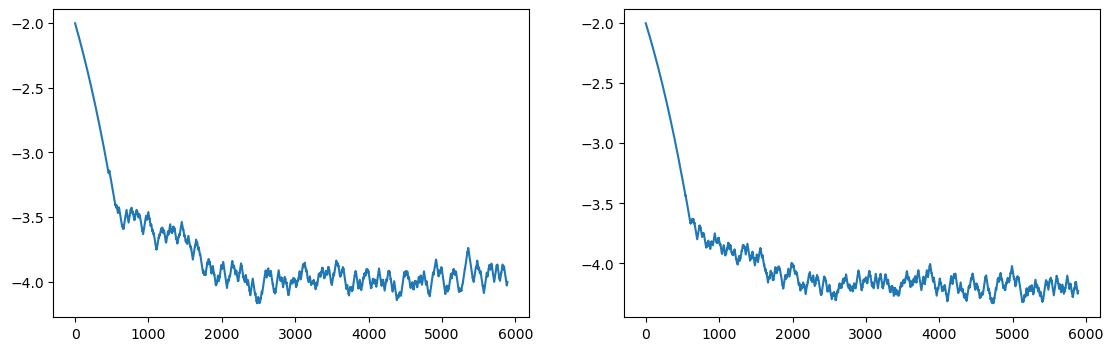

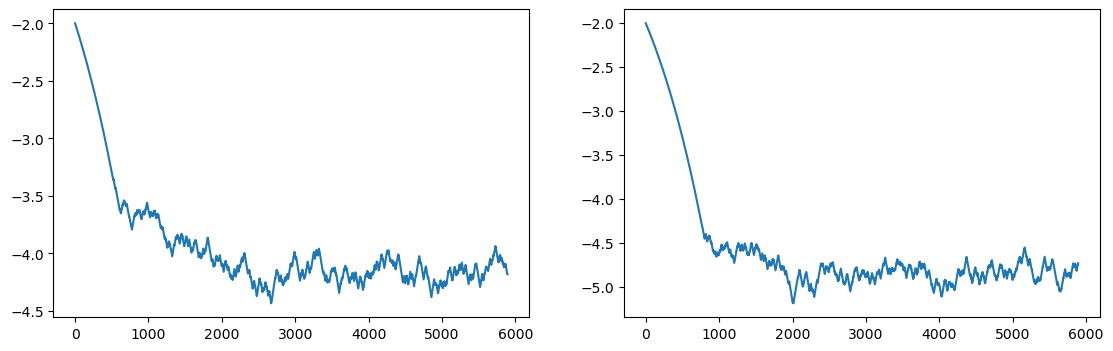

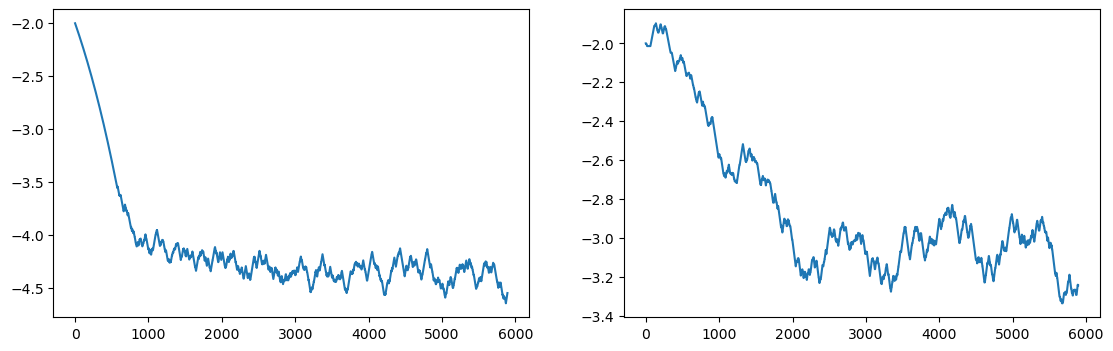

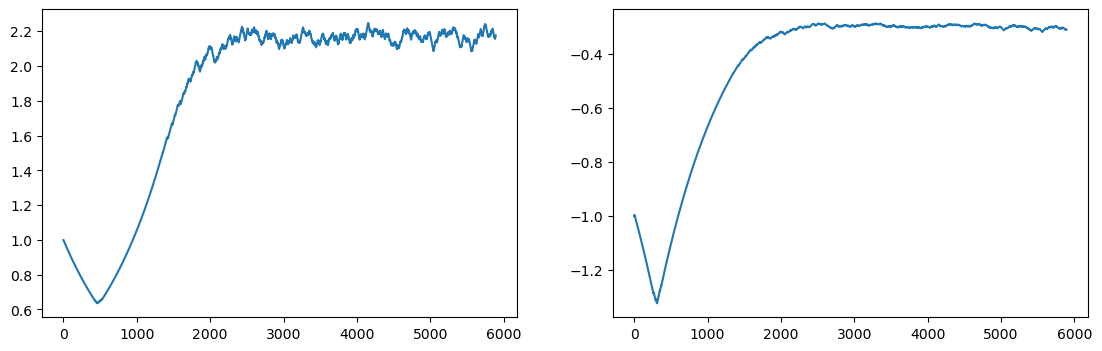

In [7]:
#plotting the parameters' trajectories during the EE algorithm

fig, (ax0,ax1) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax0.set_title("Generator-Generator Edge parameter", fontsize = 20)
ax0.plot(parlist[0])
#ax1.set_title("Generator-Load Edge parameter", fontsize = 20)
ax1.plot(parlist[1])
plt.savefig("nt"+mod_type+name+'parmater diagnostics0.svg',dpi=300, format="svg")
plt.show()
fig, (ax2,ax3) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax2.set_title("Generator-Interconnection Edge parameter", fontsize = 20)
ax2.plot(parlist[2])
#ax3.set_title("Load-Load Edge parameter", fontsize = 20)
ax3.plot(parlist[3])
plt.savefig("nt"+mod_type+name+'parmater diagnostics1.svg',dpi=300, format="svg")
plt.show()
fig,(ax4,ax5) = plt.subplots(nrows=1,ncols= 2, figsize=(13.5,4))
#ax4.set_title("Load-Interconnection Edge parameter", fontsize = 20)
ax4.plot(parlist[4])
#ax5.set_title("Interconnection-Interconnection Edge parameter", fontsize = 20)
ax5.plot(parlist[5])
plt.savefig("nt"+mod_type+name+'parmater diagnostics2.svg',dpi=300, format="svg")
plt.show()
fig2,(ax20,ax21) = plt.subplots(nrows=1,ncols=2,figsize=(13.5,4))
#ax20.set_title("triangles parameter", fontsize = 20)
ax20.plot(parlist[6])
#ax21.set_title("2-triangles parameter", fontsize = 20)
ax21.plot(parlist[7])
plt.savefig("nt"+mod_type+name+'parmater diagnostics3.svg',dpi=300, format="svg")
plt.show()

In [8]:
file.write("The estimation resulted in the following parameters: \n"+str(list(EEparams))+"\n")

217

### Constrained Monte-Carlo sampling

We proceed to the actual generative part of our methodology by using the parameters estimated previously and the algorithm for constrained Monte-Carlo sampling introduced in https://doi.org/10.48550/arXiv.1806.11276

In [9]:
#monte-carlo sampling with the constrained algorithm
mean_list,synth,obslist = est.pg_MHergm_conn(startconn,obs,EEparams,countlist, obs_comp,fast_obs_comp,1000000)
sellist = est.selector(synth)
print("The procedure has generated "+str(len(sellist))+" synthetic samples")
Glist2,clustlist,avg_typedeg,ac_list = sc.synth_selection2(sellist,ordlist)

100%|██████████| 1000000/1000000 [01:25<00:00, 11659.98it/s]


44158
10191
The procedure has generated 250 synthetic samples


100%|██████████| 250/250 [00:00<00:00, 537.31it/s]


Next, we plot some of the statiscs of interest for each generated network. In red it is reported the value of the statistic for the reference grid whereas in green it is reported the average value of the statistic across the generated ensemble.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


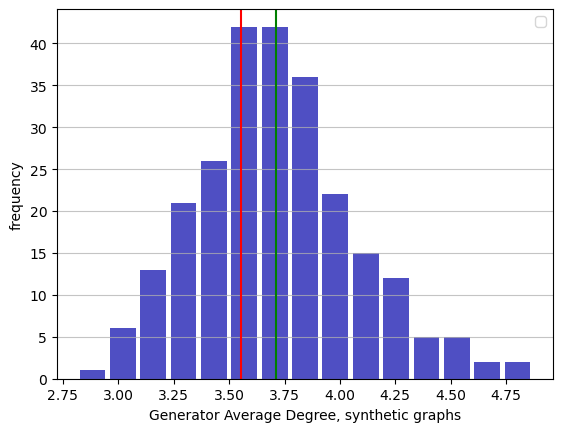

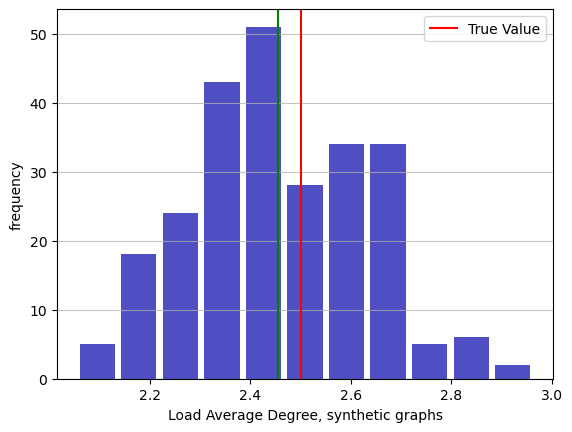

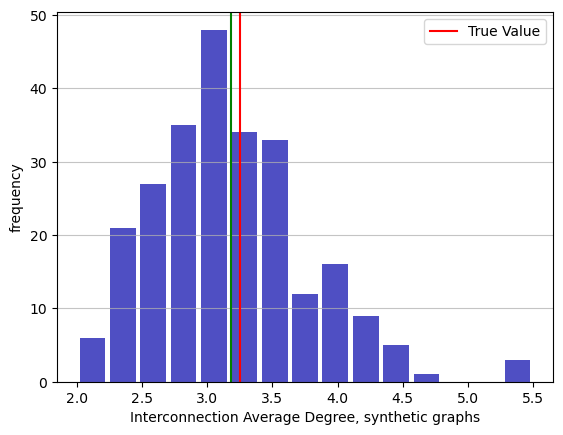

100%|██████████| 250/250 [00:00<00:00, 13167.44it/s]


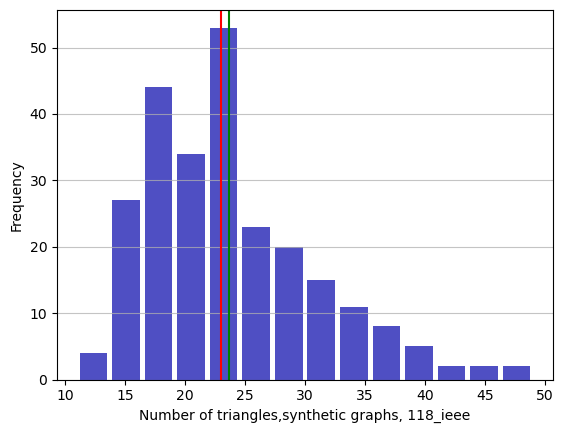

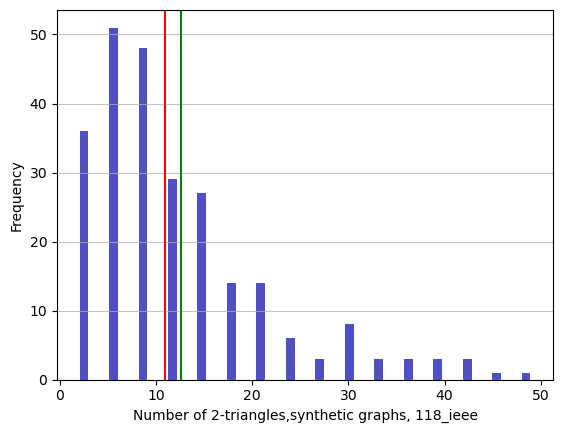

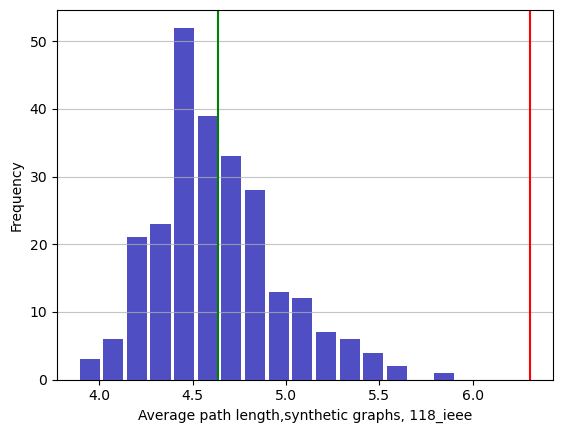

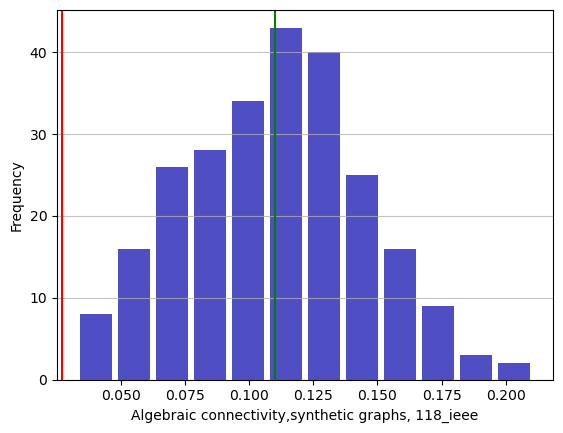

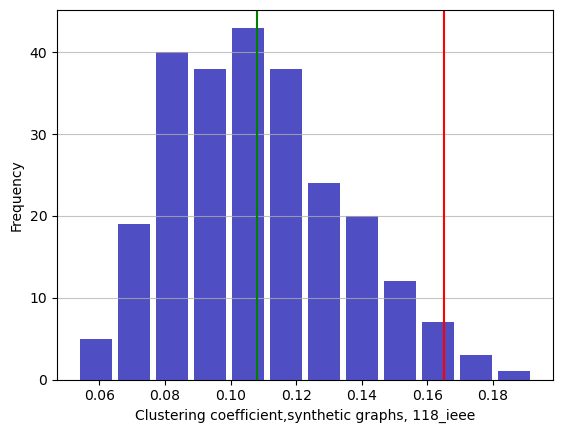

78

In [11]:
#plotting the results

degarray = np.array(avg_typedeg).T

n, bins, patches = plt.hist(x=degarray[0], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Generator Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Generators,'+name)
plt.axvline(x=k1,color='red')
plt.axvline(x=np.mean(degarray[0]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig('sdeggens'+mod_type+name+'.svg',dpi=300, format="svg")
plt.show()

rmean_list.append(k1)

file.write("Generator Average Degree, benchmark value: "+ str(rmean_list[0])+"\n")

file.write("Generator Average Degree: mean "+ str(np.mean(degarray[0])) + " std dev "+ str(np.std(degarray[0])) + "\n" )





n, bins, patches = plt.hist(x=degarray[1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Load Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Loads, '+name)
plt.axvline(x=k2,color='red',label='True Value')
plt.axvline(x=np.mean(degarray[1]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig('sdegloads'+mod_type+name+'.svg',dpi=300, format="svg")
plt.show()

rmean_list.append(k2)

file.write("Load Average Degree, benchmark value: "+ str(rmean_list[1])+"\n")

file.write("Load Average Degree: mean "+ str(np.mean(degarray[1])) + " std dev "+ str(np.std(degarray[1])) + "\n" )


n, bins, patches = plt.hist(x=degarray[2], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interconnection Average Degree, synthetic graphs')
plt.ylabel('frequency')
#plt.title('Interconnections, '+name)
plt.axvline(x=k3,color='red',label='True Value')
plt.axvline(x=np.mean(degarray[2]),color='green')
maxfreq = n.max()
plt.legend(loc='upper right')
plt.savefig('sdegints'+mod_type+name+'.svg',dpi=300, format="svg")
plt.show()

rmean_list.append(k3)

file.write("Interconnection Average Degree, benchmark value: "+ str(rmean_list[2])+"\n")

file.write("Interconnection Average Degree: mean "+ str(np.mean(degarray[2])) + " std dev "+ str(np.std(degarray[2])) + "\n" )


trilist = []
for i in tqdm(range(len(Glist2))):
    trilist.append(sum(nx.triangles(Glist2[i].to_undirected()).values())/3)
trilist2 = [hc.compute_2_triangle(mat) for mat in tqdm(sellist)]


n, bins, patches = plt.hist(x=trilist, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of triangles,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Triangles, '+name)
plt.axvline(x=genobs[6],color='red')
plt.axvline(x=np.mean(trilist),color='green')
plt.savefig('stris'+mod_type+name+'.svg',dpi=300, format="svg")
plt.show()

rmean_list.append(genobs[6])

file.write("Triangles, benchmark value: "+ str(rmean_list[3])+"\n")

file.write("Triangles: mean "+ str(np.mean(trilist)) + " std dev "+ str(np.std(trilist)) + "\n" )


n, bins, patches = plt.hist(x=trilist2, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.3)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Number of 2-triangles,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('2-Triangles, '+name)
plt.axvline(x=genobs[7],color='red')
plt.axvline(x=np.mean(trilist2),color='green')
plt.savefig('trians2'+name+'.svg',dpi=300, format="svg")
plt.show()

rmean_list.append(genobs[7])
file.write("2-Triangles, benchmark value: "+ str(rmean_list[4])+"\n")
file.write("2-Triangles: mean "+ str(np.mean(trilist2)) + " std dev "+ str(np.std(trilist2)) + "\n" )



paths = [nx.average_shortest_path_length(G.to_undirected()) for G in Glist2]
n, bins, patches = plt.hist(x=paths, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Average path length,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Avgerage path, '+name)
plt.axvline(x=nx.average_shortest_path_length(nx.from_numpy_array(ordmat).to_undirected()),color='red')
plt.axvline(x=np.mean(paths),color='green')
plt.savefig('apl'+name+'.svg',dpi=300, format="svg")
plt.show()
rmean_list.append(nx.average_shortest_path_length(nx.from_numpy_array(ordmat).to_undirected()))
file.write("Average path length, benchmark value: "+ str(rmean_list[5])+"\n")
file.write("Average path length: mean "+ str(np.mean(paths)) + " std dev "+ str(np.std(paths)) + "\n" )




n, bins, patches = plt.hist(x=ac_list, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Algebraic connectivity,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Algebraic connectivity, '+name)
plt.axvline(x=sc.alg_conn(ordmat),color='red')
plt.axvline(x=np.mean(ac_list),color='green')
plt.savefig('acsin'+name+'.svg',dpi=300, format="svg")
plt.show()
rmean_list.append(sc.alg_conn(ordmat))
file.write("Algebraic connectivity, benchmark value: "+ str(rmean_list[6])+"\n")
file.write("Algebraic connectivity: mean "+ str(np.mean(ac_list)) + " std dev "+ str(np.std(ac_list)) + "\n" )




clusts = [sc.clustering_coeff(G.to_undirected()) for G in Glist2]
n, bins, patches = plt.hist(x=clusts, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Clustering coefficient,synthetic graphs, '+name)
plt.ylabel('Frequency')
#plt.title('Avgerage path, '+name)
plt.axvline(x=sc.clustering_coeff(nx.from_numpy_array(ordmat).to_undirected()),color='red')
plt.axvline(x=np.mean(clusts),color='green')
plt.savefig('clustcoeff_'+name+'.svg',dpi=300, format="svg")
plt.show()
rmean_list.append(sc.clustering_coeff(nx.from_numpy_array(ordmat).to_undirected()))
file.write("Clustering coefficient, benchmark value: "+ str(rmean_list[7])+"\n")
file.write("Clustering coefficient: mean "+ str(np.mean(clusts)) + " std dev "+ str(np.std(clusts)) + "\n" )



In [12]:
file.close()